# Amsterdam Weather Analysis with Conditional Mixture Models

This notebook analyzes hourly weather data from Amsterdam using conditional Gaussian mixture models to understand the relationships between temperature, wind speed, and solar radiation over time.

**Key Questions:**
- How do weather variables relate to seasonal and daily cycles?
- What are the typical weather patterns at different times of year?
- How well can we model the joint distribution of weather variables?

**Data:** Hourly weather data from Amsterdam (2014-2023) including temperature, wind speed, and solar radiation.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import time
warnings.filterwarnings('ignore')

from cgmm import ConditionalGMMRegressor, MixtureOfExpertsRegressor, DiscriminativeConditionalGMMRegressor

# Set style for better plots
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
np.random.seed(42)


## Data Loading and Preprocessing

Load the Amsterdam weather data and prepare it for analysis. We'll focus on three key variables:
- **Temperature** (`temp_c`): Air temperature in Celsius
- **Wind Speed** (`wind_ms`): Wind speed in m/s (log-transformed)
- **Solar Radiation** (`ghi_wm2`): Global horizontal irradiance in W/m² (log-transformed)

The conditioning variables will be derived from the datetime to capture seasonal and daily patterns.


In [2]:
# Load the weather data
df = pd.read_csv('data/amsterdam_hourly.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"\nMissing values:")
print(df[['temp_c', 'wind_ms', 'ghi_wm2']].isnull().sum())

# Remove rows with missing values
df_clean = df[['datetime', 'temp_c', 'wind_ms', 'ghi_wm2']].dropna()
print(f"\nClean dataset shape: {df_clean.shape}")

# Display basic statistics
print("\nBasic statistics:")
print(df_clean[['temp_c', 'wind_ms', 'ghi_wm2']].describe())


Dataset shape: (52608, 7)
Date range: 2019-01-01 00:00:00 to 2024-12-31 23:00:00

Missing values:
temp_c     0
wind_ms    0
ghi_wm2    0
dtype: int64

Clean dataset shape: (52608, 4)

Basic statistics:
             temp_c       wind_ms       ghi_wm2
count  52608.000000  52608.000000  52608.000000
mean      11.327055     15.325150    128.068602
std        6.339285      7.743829    198.913009
min      -10.300000      0.000000      0.000000
25%        6.700000      9.400000      0.000000
50%       10.900000     14.100000      5.000000
75%       15.900000     19.700000    195.000000
max       38.000000     61.400000    869.000000


In [3]:
# Create time-based features for conditioning
df_clean['year'] = df_clean['datetime'].dt.year
df_clean['month'] = df_clean['datetime'].dt.month
df_clean['day_of_year'] = df_clean['datetime'].dt.dayofyear
df_clean['hour'] = df_clean['datetime'].dt.hour

# Create cyclical features
# Annual cycle (seasonal)
df_clean['annual_sin'] = np.sin(2 * np.pi * df_clean['day_of_year'] / 365.25)
df_clean['annual_cos'] = np.cos(2 * np.pi * df_clean['day_of_year'] / 365.25)

# Daily cycle (diurnal)
df_clean['daily_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
df_clean['daily_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)

print("Created cyclical features:")
print("- Annual cycle: annual_sin, annual_cos")
print("- Daily cycle: daily_sin, daily_cos")


Created cyclical features:
- Annual cycle: annual_sin, annual_cos
- Daily cycle: daily_sin, daily_cos


In [4]:
# Transform positive variables using log(1+x) to handle zeros
df_clean['wind_ms_log'] = np.log1p(df_clean['wind_ms'])  # log(1 + wind_ms)
df_clean['ghi_wm2_log'] = np.log1p(df_clean['ghi_wm2'])  # log(1 + ghi_wm2)

# Prepare target variables (weather variables)
targets = ['temp_c', 'wind_ms_log', 'ghi_wm2_log']
y = df_clean[targets].values

# Prepare conditioning variables (time-based features)
conditioning_vars = ['annual_sin', 'annual_cos', 'daily_sin', 'daily_cos']
X = df_clean[conditioning_vars].values

print(f"Target variables: {targets}")
print(f"Conditioning variables: {conditioning_vars}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Show transformation effect
print("\nTransformation comparison:")
print("Wind speed - Original vs Log-transformed:")
print(f"  Original: mean={df_clean['wind_ms'].mean():.2f}, std={df_clean['wind_ms'].std():.2f}")
print(f"  Log(1+x): mean={df_clean['wind_ms_log'].mean():.2f}, std={df_clean['wind_ms_log'].std():.2f}")
print("\nSolar radiation - Original vs Log-transformed:")
print(f"  Original: mean={df_clean['ghi_wm2'].mean():.2f}, std={df_clean['ghi_wm2'].std():.2f}")
print(f"  Log(1+x): mean={df_clean['ghi_wm2_log'].mean():.2f}, std={df_clean['ghi_wm2_log'].std():.2f}")


Target variables: ['temp_c', 'wind_ms_log', 'ghi_wm2_log']
Conditioning variables: ['annual_sin', 'annual_cos', 'daily_sin', 'daily_cos']
X shape: (52608, 4), y shape: (52608, 3)

Transformation comparison:
Wind speed - Original vs Log-transformed:
  Original: mean=15.33, std=7.74
  Log(1+x): mean=2.68, std=0.50

Solar radiation - Original vs Log-transformed:
  Original: mean=128.07, std=198.91
  Log(1+x): mean=2.55, std=2.63


## Discriminative Model Investigation

Systematic investigation of the Discriminative Conditional GMM Regressor on the FULL dataset with various hyperparameter settings.


In [5]:
# Define hyperparameter grid for systematic testing
hyperparameter_grid = [
    # (n_components, max_iter, tol, weight_step)
    (10, 100, 1e-3, 1),
    (5, 100, 1e-3, 1),
    (3, 100, 1e-3, 1),

    (3, 200, 1e-4, 0.5),
    (3, 300, 1e-5, 0.1),
    (3, 500, 1e-6, 0.05),
    (5, 100, 1e-3, 1),
    (5, 200, 1e-4, 0.5),
    (5, 300, 1e-5, 0.1),
    (5, 500, 1e-6, 0.05),
    (8, 100, 1e-3, 1),
    (8, 200, 1e-4, 0.5),
    (8, 300, 1e-5, 0.1),
    (8, 500, 1e-6, 0.05),
    (10, 200, 1e-4, 5),
    (10, 300, 1e-5, 1),
    (10, 500, 1e-6, 0.5),
    (15, 200, 1e-4, 5),
    (15, 300, 1e-5, 1),
    (15, 500, 1e-6, 0.5)
]
hyperparameter_grid = hyperparameter_grid[:3]

print(f"Testing {len(hyperparameter_grid)} hyperparameter combinations on FULL dataset")
print(f"Dataset size: X={X.shape}, y={y.shape}")
print("\nHyperparameter combinations:")
for i, (n_comp, max_iter, tol, weight_step) in enumerate(hyperparameter_grid):
    print(f"  {i+1:2d}. n_components={n_comp:2d}, max_iter={max_iter:3d}, tol={tol:.0e}, weight_step={weight_step:.3f}")


Testing 3 hyperparameter combinations on FULL dataset
Dataset size: X=(52608, 4), y=(52608, 3)

Hyperparameter combinations:
   1. n_components=10, max_iter=100, tol=1e-03, weight_step=1.000
   2. n_components= 5, max_iter=100, tol=1e-03, weight_step=1.000
   3. n_components= 3, max_iter=100, tol=1e-03, weight_step=1.000


In [6]:
# Test all hyperparameter combinations on FULL dataset
results = []

print("\n=== DISCRIMINATIVE MODEL HYPERPARAMETER TESTING ===")
print("Testing on FULL dataset with consistent evaluation")
print("\nProgress:")

for i, (n_components, max_iter, tol, weight_step) in enumerate(hyperparameter_grid):
    print(f"\n{i+1:2d}/{len(hyperparameter_grid)}: n_comp={n_components:2d}, max_iter={max_iter:3d}, tol={tol:.0e}, weight_step={weight_step:.3f}")

    # Create model with current hyperparameters
    model = DiscriminativeConditionalGMMRegressor(
        n_components=n_components,
        max_iter=max_iter,
        tol=tol,
        weight_step=weight_step,
        random_state=42
    )   
    
    # Train on FULL dataset
    start_time = time.time()    
    model.fit(X, y)
    fit_time = time.time() - start_time
    print(f"Fit time: {fit_time:.2f}s")
    
    # Evaluate on FULL dataset (consistent evaluation)
    start_time = time.time()    
    y_pred = model.predict(X)
    predict_time = time.time() - start_time
    print(f"Predict time: {predict_time:.2f}s")
    
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    start_time = time.time()    
    log_likelihood = model.score(X, y)
    score_time = time.time() - start_time
    print(f"Score time: {score_time:.2f}s")
    
    # Get convergence info
    iterations = getattr(model, 'n_iter_', 'Unknown')
    converged = getattr(model, 'converged_', 'Unknown')
    
    # Store results
    result = {
        'n_components': n_components,
        'max_iter': max_iter,
        'tol': tol,
        'weight_step': weight_step,
        'iterations': iterations,
        'converged': converged,
        'mse': mse,
        'r2': r2,
        'log_likelihood': log_likelihood
    }
    results.append(result)
    
    # Print results
    print(f"    Iterations: {iterations}, Converged: {converged}")
    print(f"    MSE: {mse:.4f}, R²: {r2:.4f}, Log-likelihood: {log_likelihood:.4f}")
    
    # Check for issues
    if np.isnan(log_likelihood) or np.isinf(log_likelihood):
        print(f"    WARNING: Invalid log-likelihood!")
    if iterations == max_iter:
        print(f"    WARNING: Hit max_iter limit!")


print("\n=== TESTING COMPLETED ===")



=== DISCRIMINATIVE MODEL HYPERPARAMETER TESTING ===
Testing on FULL dataset with consistent evaluation

Progress:

 1/3: n_comp=10, max_iter=100, tol=1e-03, weight_step=1.000
Fit time: 17.96s
Predict time: 4.69s
Score time: 8.76s
    Iterations: 100, Converged: False
    MSE: 3.8016, R²: 0.5948, Log-likelihood: -1.0540

 2/3: n_comp= 5, max_iter=100, tol=1e-03, weight_step=1.000
Fit time: 8.38s
Predict time: 2.56s
Score time: 4.58s
    Iterations: 100, Converged: False
    MSE: 3.9841, R²: 0.5875, Log-likelihood: -1.1583

 3/3: n_comp= 3, max_iter=100, tol=1e-03, weight_step=1.000
Fit time: 5.14s
Predict time: 1.46s
Score time: 2.81s
    Iterations: 100, Converged: False
    MSE: 4.0620, R²: 0.5835, Log-likelihood: -1.1648

=== TESTING COMPLETED ===


In [7]:
# Analyze results
results_df = pd.DataFrame(results)

print("\n=== DISCRIMINATIVE MODEL RESULTS ANALYSIS ===")
print(f"Successful runs: {len(results_df.dropna())}/{len(results_df)}")

# Sort by log-likelihood (best first)
valid_results = results_df.dropna().copy()
valid_results = valid_results.sort_values('log_likelihood', ascending=False)

print("\nTop 10 configurations by log-likelihood:")
print(valid_results[['n_components', 'max_iter', 'tol', 'weight_step', 'iterations', 'converged', 'log_likelihood', 'r2']].head(10).to_string(index=False))

print("\nWorst 5 configurations by log-likelihood:")
print(valid_results[['n_components', 'max_iter', 'tol', 'weight_step', 'iterations', 'converged', 'log_likelihood', 'r2']].tail(5).to_string(index=False))

# Summary statistics
print(f"\nLog-likelihood statistics:")
print(f"  Mean: {valid_results['log_likelihood'].mean():.4f}")
print(f"  Std:  {valid_results['log_likelihood'].std():.4f}")
print(f"  Min:  {valid_results['log_likelihood'].min():.4f}")
print(f"  Max:  {valid_results['log_likelihood'].max():.4f}")

print(f"\nIteration statistics:")
print(f"  Mean: {valid_results['iterations'].mean():.1f}")
print(f"  Std:  {valid_results['iterations'].std():.1f}")
print(f"  Min:  {valid_results['iterations'].min()}")
print(f"  Max:  {valid_results['iterations'].max()}")

print(f"\nConvergence rate: {(valid_results['converged'] == True).mean():.1%}")



=== DISCRIMINATIVE MODEL RESULTS ANALYSIS ===
Successful runs: 3/3

Top 10 configurations by log-likelihood:
 n_components  max_iter   tol  weight_step  iterations  converged  log_likelihood       r2
           10       100 0.001            1         100      False       -1.053988 0.594805
            5       100 0.001            1         100      False       -1.158277 0.587532
            3       100 0.001            1         100      False       -1.164829 0.583504

Worst 5 configurations by log-likelihood:
 n_components  max_iter   tol  weight_step  iterations  converged  log_likelihood       r2
           10       100 0.001            1         100      False       -1.053988 0.594805
            5       100 0.001            1         100      False       -1.158277 0.587532
            3       100 0.001            1         100      False       -1.164829 0.583504

Log-likelihood statistics:
  Mean: -1.1257
  Std:  0.0622
  Min:  -1.1648
  Max:  -1.0540

Iteration statistics:
  Mea

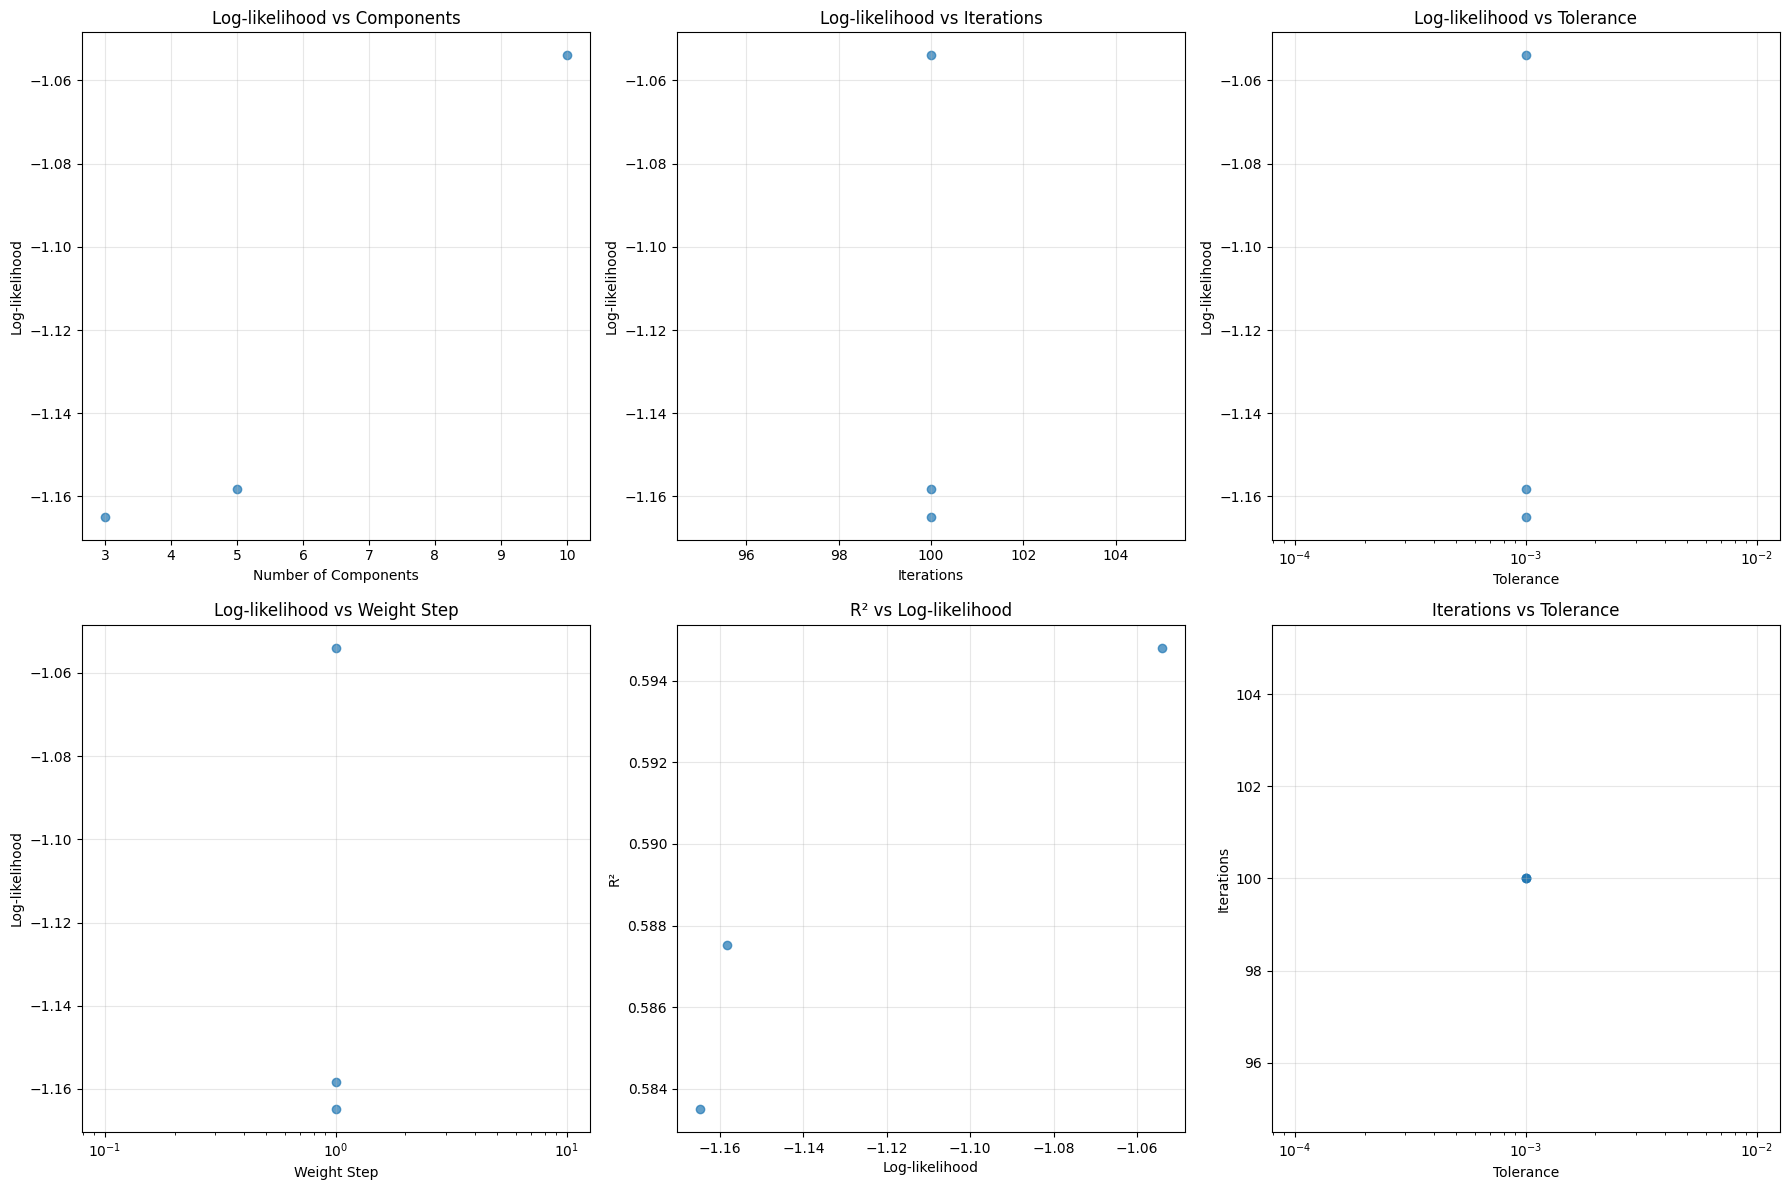

In [8]:
# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Log-likelihood vs n_components
axes[0, 0].scatter(valid_results['n_components'], valid_results['log_likelihood'], alpha=0.7)
axes[0, 0].set_xlabel('Number of Components')
axes[0, 0].set_ylabel('Log-likelihood')
axes[0, 0].set_title('Log-likelihood vs Components')
axes[0, 0].grid(True, alpha=0.3)

# Log-likelihood vs iterations
axes[0, 1].scatter(valid_results['iterations'], valid_results['log_likelihood'], alpha=0.7)
axes[0, 1].set_xlabel('Iterations')
axes[0, 1].set_ylabel('Log-likelihood')
axes[0, 1].set_title('Log-likelihood vs Iterations')
axes[0, 1].grid(True, alpha=0.3)

# Log-likelihood vs tolerance
axes[0, 2].scatter(valid_results['tol'], valid_results['log_likelihood'], alpha=0.7)
axes[0, 2].set_xlabel('Tolerance')
axes[0, 2].set_ylabel('Log-likelihood')
axes[0, 2].set_title('Log-likelihood vs Tolerance')
axes[0, 2].set_xscale('log')
axes[0, 2].grid(True, alpha=0.3)

# Log-likelihood vs weight_step
axes[1, 0].scatter(valid_results['weight_step'], valid_results['log_likelihood'], alpha=0.7)
axes[1, 0].set_xlabel('Weight Step')
axes[1, 0].set_ylabel('Log-likelihood')
axes[1, 0].set_title('Log-likelihood vs Weight Step')
axes[1, 0].set_xscale('log')
axes[1, 0].grid(True, alpha=0.3)

# R² vs log-likelihood
axes[1, 1].scatter(valid_results['log_likelihood'], valid_results['r2'], alpha=0.7)
axes[1, 1].set_xlabel('Log-likelihood')
axes[1, 1].set_ylabel('R²')
axes[1, 1].set_title('R² vs Log-likelihood')
axes[1, 1].grid(True, alpha=0.3)

# Iterations vs tolerance
axes[1, 2].scatter(valid_results['tol'], valid_results['iterations'], alpha=0.7)
axes[1, 2].set_xlabel('Tolerance')
axes[1, 2].set_ylabel('Iterations')
axes[1, 2].set_title('Iterations vs Tolerance')
axes[1, 2].set_xscale('log')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [9]:
# Train the best model and analyze it in detail
best_config = valid_results.iloc[0]
print(f"\n=== BEST MODEL ANALYSIS ===")
print(f"Best configuration:")
print(f"  n_components: {best_config['n_components']}")
print(f"  max_iter: {best_config['max_iter']}")
print(f"  tol: {best_config['tol']}")
print(f"  weight_step: {best_config['weight_step']}")
print(f"  Performance: log_likelihood={best_config['log_likelihood']:.4f}, r2={best_config['r2']:.4f}")

# Train the best model
best_model = DiscriminativeConditionalGMMRegressor(
    n_components=int(best_config['n_components']),
    max_iter=int(best_config['max_iter']),
    tol=best_config['tol'],
    weight_step=best_config['weight_step'],
    random_state=42
)

print(f"\nTraining best model on FULL dataset...")
best_model.fit(X, y)

# Final evaluation
y_pred_best = best_model.predict(X)
mse_best = mean_squared_error(y, y_pred_best)
r2_best = r2_score(y, y_pred_best)
log_likelihood_best = best_model.score(X, y)

print(f"\nFinal performance on FULL dataset:")
print(f"  MSE: {mse_best:.4f}")
print(f"  R²: {r2_best:.4f}")
print(f"  Log-likelihood: {log_likelihood_best:.4f}")
print(f"  Iterations: {getattr(best_model, 'n_iter_', 'Unknown')}")
print(f"  Converged: {getattr(best_model, 'converged_', 'Unknown')}")

# Check prediction ranges
print(f"\nPrediction analysis:")
print(f"  Target range: [{y.min():.3f}, {y.max():.3f}]")
print(f"  Prediction range: [{y_pred_best.min():.3f}, {y_pred_best.max():.3f}]")
print(f"  Target mean: {y.mean():.3f}")
print(f"  Prediction mean: {y_pred_best.mean():.3f}")

# Check for any issues
nan_pred = np.isnan(y_pred_best).sum()
inf_pred = np.isinf(y_pred_best).sum()
if nan_pred > 0:
    print(f"  WARNING: {nan_pred} NaN predictions!")
if inf_pred > 0:
    print(f"  WARNING: {inf_pred} infinite predictions!")

print(f"\n=== BEST MODEL ANALYSIS COMPLETE ===")



=== BEST MODEL ANALYSIS ===
Best configuration:
  n_components: 10
  max_iter: 100
  tol: 0.001
  weight_step: 1
  Performance: log_likelihood=-1.0540, r2=0.5948

Training best model on FULL dataset...

Final performance on FULL dataset:
  MSE: 3.8016
  R²: 0.5948
  Log-likelihood: -1.0540
  Iterations: 100
  Converged: False

Prediction analysis:
  Target range: [-10.300, 38.000]
  Prediction range: [-0.024, 22.559]
  Target mean: 5.518
  Prediction mean: 5.513

=== BEST MODEL ANALYSIS COMPLETE ===


# Amsterdam Weather Analysis with Conditional Mixture Models

This notebook analyzes hourly weather data from Amsterdam using conditional Gaussian mixture models to understand the relationships between temperature, wind speed, and solar radiation over time.

**Key Questions:**
- How do weather variables relate to seasonal and daily cycles?
- What are the typical weather patterns at different times of year?
- How well can we model the joint distribution of weather variables?

**Data:** Hourly weather data from Amsterdam (2014-2023) including temperature, wind speed, and solar radiation.


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

from cgmm import ConditionalGMMRegressor, MixtureOfExpertsRegressor, DiscriminativeConditionalGMMRegressor

# Set style for better plots
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
np.random.seed(42)


## Data Loading and Preprocessing

Load the Amsterdam weather data and prepare it for analysis. We'll focus on three key variables:
- **Temperature** (`temp_c`): Air temperature in Celsius
- **Wind Speed** (`wind_ms`): Wind speed in m/s (log-transformed)
- **Solar Radiation** (`ghi_wm2`): Global horizontal irradiance in W/m² (log-transformed)

The conditioning variables will be derived from the datetime to capture seasonal and daily patterns.


In [11]:
# Load the weather data
df = pd.read_csv('data/amsterdam_hourly.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"\nMissing values:")
print(df[['temp_c', 'wind_ms', 'ghi_wm2']].isnull().sum())

# Remove rows with missing values
df_clean = df[['datetime', 'temp_c', 'wind_ms', 'ghi_wm2']].dropna()
print(f"\nClean dataset shape: {df_clean.shape}")

# Display basic statistics
print("\nBasic statistics:")
print(df_clean[['temp_c', 'wind_ms', 'ghi_wm2']].describe())


Dataset shape: (52608, 7)
Date range: 2019-01-01 00:00:00 to 2024-12-31 23:00:00

Missing values:
temp_c     0
wind_ms    0
ghi_wm2    0
dtype: int64

Clean dataset shape: (52608, 4)

Basic statistics:
             temp_c       wind_ms       ghi_wm2
count  52608.000000  52608.000000  52608.000000
mean      11.327055     15.325150    128.068602
std        6.339285      7.743829    198.913009
min      -10.300000      0.000000      0.000000
25%        6.700000      9.400000      0.000000
50%       10.900000     14.100000      5.000000
75%       15.900000     19.700000    195.000000
max       38.000000     61.400000    869.000000


In [12]:
# Create time-based features for conditioning
df_clean['year'] = df_clean['datetime'].dt.year
df_clean['month'] = df_clean['datetime'].dt.month
df_clean['day_of_year'] = df_clean['datetime'].dt.dayofyear
df_clean['hour'] = df_clean['datetime'].dt.hour

# Create cyclical features
# Annual cycle (seasonal)
df_clean['annual_sin'] = np.sin(2 * np.pi * df_clean['day_of_year'] / 365.25)
df_clean['annual_cos'] = np.cos(2 * np.pi * df_clean['day_of_year'] / 365.25)

# Daily cycle (diurnal)
df_clean['daily_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
df_clean['daily_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)

print("Created cyclical features:")
print("- Annual cycle: annual_sin, annual_cos")
print("- Daily cycle: daily_sin, daily_cos")


Created cyclical features:
- Annual cycle: annual_sin, annual_cos
- Daily cycle: daily_sin, daily_cos


In [13]:
# Transform positive variables using log(1+x) to handle zeros
df_clean['wind_ms_log'] = np.log1p(df_clean['wind_ms'])  # log(1 + wind_ms)
df_clean['ghi_wm2_log'] = np.log1p(df_clean['ghi_wm2'])  # log(1 + ghi_wm2)

# Prepare target variables (weather variables)
targets = ['temp_c', 'wind_ms_log', 'ghi_wm2_log']
y = df_clean[targets].values

# Prepare conditioning variables (time-based features)
conditioning_vars = ['annual_sin', 'annual_cos', 'daily_sin', 'daily_cos']
X = df_clean[conditioning_vars].values

print(f"Target variables: {targets}")
print(f"Conditioning variables: {conditioning_vars}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Show transformation effect
print("\nTransformation comparison:")
print("Wind speed - Original vs Log-transformed:")
print(f"  Original: mean={df_clean['wind_ms'].mean():.2f}, std={df_clean['wind_ms'].std():.2f}")
print(f"  Log(1+x): mean={df_clean['wind_ms_log'].mean():.2f}, std={df_clean['wind_ms_log'].std():.2f}")
print("\nSolar radiation - Original vs Log-transformed:")
print(f"  Original: mean={df_clean['ghi_wm2'].mean():.2f}, std={df_clean['ghi_wm2'].std():.2f}")
print(f"  Log(1+x): mean={df_clean['ghi_wm2_log'].mean():.2f}, std={df_clean['ghi_wm2_log'].std():.2f}")


Target variables: ['temp_c', 'wind_ms_log', 'ghi_wm2_log']
Conditioning variables: ['annual_sin', 'annual_cos', 'daily_sin', 'daily_cos']
X shape: (52608, 4), y shape: (52608, 3)

Transformation comparison:
Wind speed - Original vs Log-transformed:
  Original: mean=15.33, std=7.74
  Log(1+x): mean=2.68, std=0.50

Solar radiation - Original vs Log-transformed:
  Original: mean=128.07, std=198.91
  Log(1+x): mean=2.55, std=2.63


## Data Exploration

Let's explore the weather patterns and relationships before building our models.


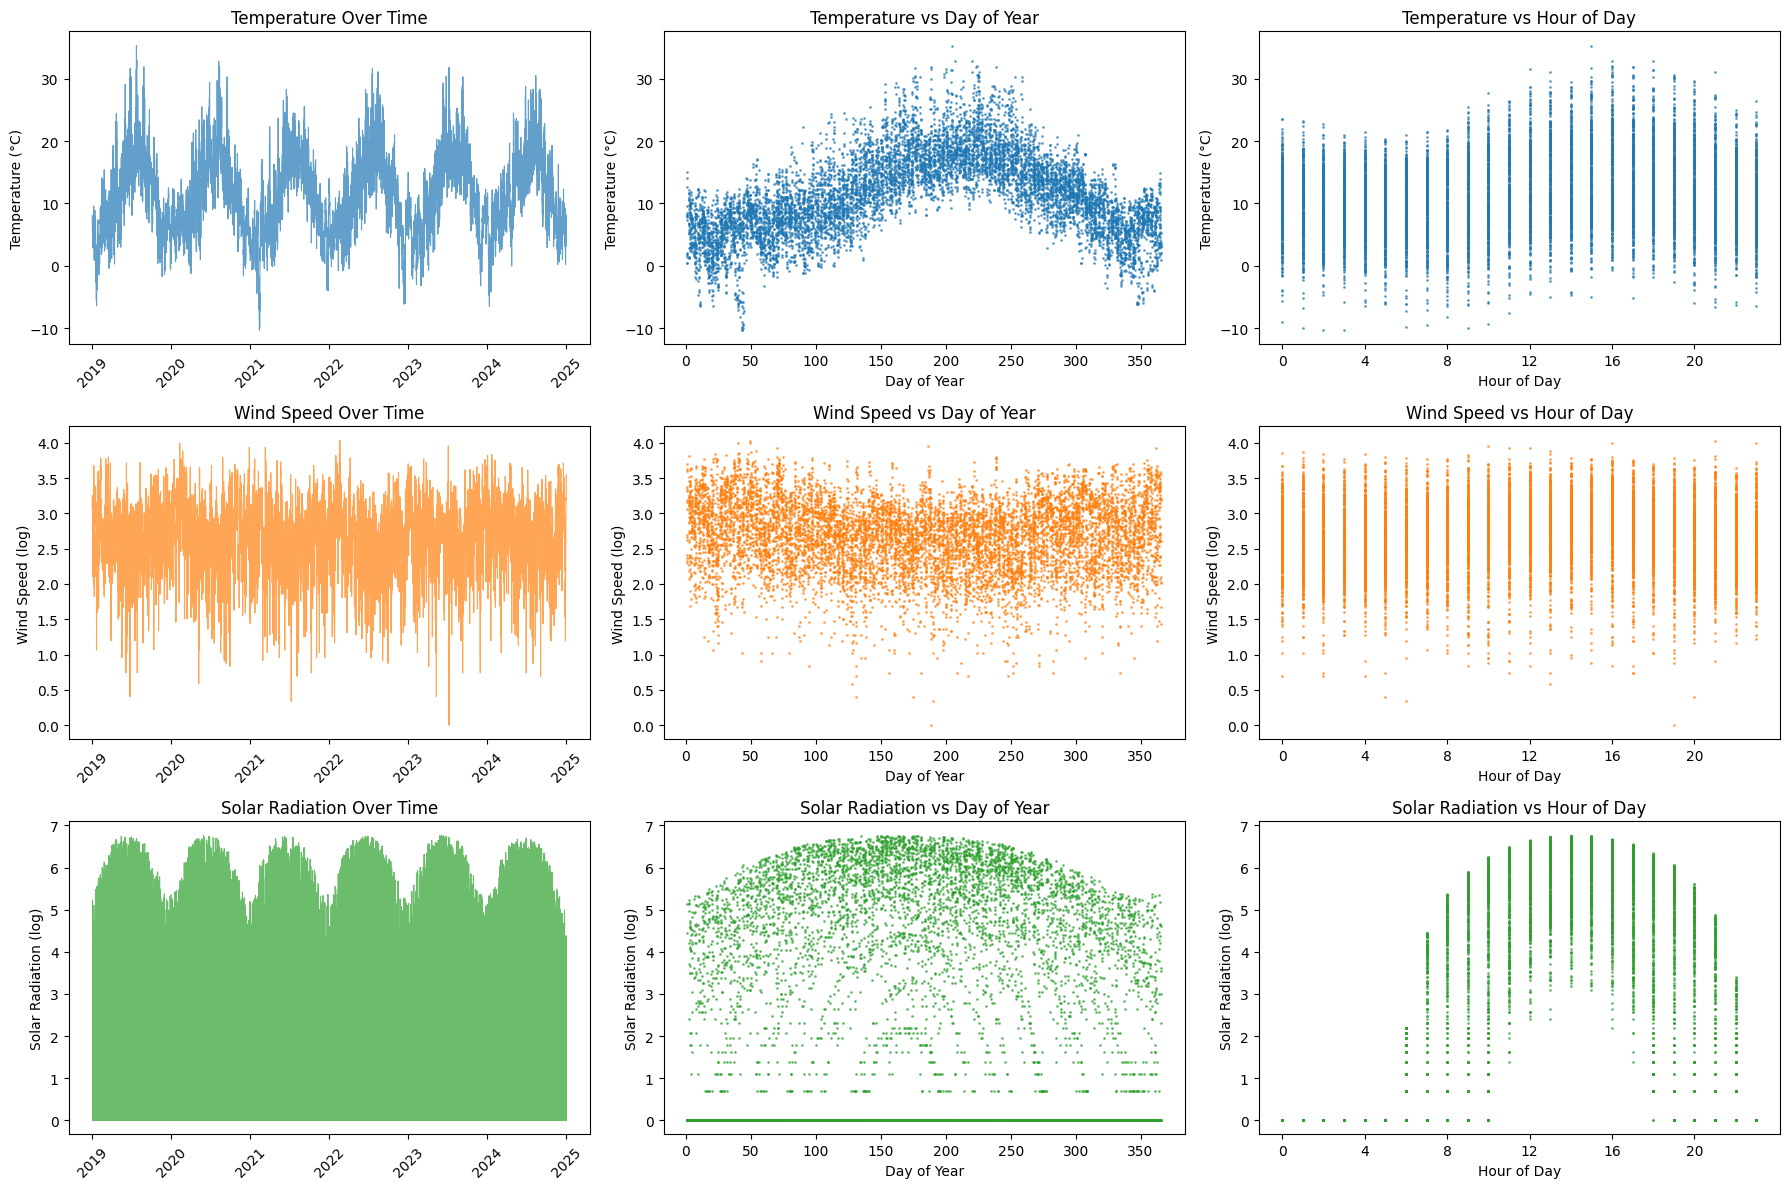

Solar Radiation Statistics:
Original values - Min: 0.0, Max: 869.0, Mean: 128.1
Log-transformed - Min: 0.000, Max: 6.768, Mean: 2.552
Percentage of zero values: 46.9%


In [14]:
# Select samples to plot
df_sample = df_clean.sample(n=10000).sort_index()


# Create 3x3 grid: rows = variables, columns = time perspectives
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

# Define colors for each variable
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
variables = ['temp_c', 'wind_ms_log', 'ghi_wm2_log']
var_names = ['Temperature', 'Wind Speed (log)', 'Solar Radiation (log)']
units = ['°C', 'log(m/s)', 'log(W/m²)']

# Row 1: Temperature
# Hourly over time
axes[0, 0].plot(df_sample['datetime'], df_sample['temp_c'], alpha=0.7, linewidth=0.8, color=colors[0])
axes[0, 0].set_title('Temperature Over Time')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].tick_params(axis='x', rotation=45)

# vs Day of Year
axes[0, 1].scatter(df_sample['day_of_year'], df_sample['temp_c'], alpha=0.6, s=1, color=colors[0])
axes[0, 1].set_title('Temperature vs Day of Year')
axes[0, 1].set_xlabel('Day of Year')
axes[0, 1].set_ylabel('Temperature (°C)')

# vs Hour of Day
axes[0, 2].scatter(df_sample['hour'], df_sample['temp_c'], alpha=0.6, s=1, color=colors[0])
axes[0, 2].set_title('Temperature vs Hour of Day')
axes[0, 2].set_xlabel('Hour of Day')
axes[0, 2].set_ylabel('Temperature (°C)')
axes[0, 2].set_xticks(range(0, 24, 4))

# Row 2: Wind Speed
# Hourly over time
axes[1, 0].plot(df_sample['datetime'], df_sample['wind_ms_log'], alpha=0.7, linewidth=0.8, color=colors[1])
axes[1, 0].set_title('Wind Speed Over Time')
axes[1, 0].set_ylabel('Wind Speed (log)')
axes[1, 0].tick_params(axis='x', rotation=45)

# vs Day of Year
axes[1, 1].scatter(df_sample['day_of_year'], df_sample['wind_ms_log'], alpha=0.6, s=1, color=colors[1])
axes[1, 1].set_title('Wind Speed vs Day of Year')
axes[1, 1].set_xlabel('Day of Year')
axes[1, 1].set_ylabel('Wind Speed (log)')

# vs Hour of Day
axes[1, 2].scatter(df_sample['hour'], df_sample['wind_ms_log'], alpha=0.6, s=1, color=colors[1])
axes[1, 2].set_title('Wind Speed vs Hour of Day')
axes[1, 2].set_xlabel('Hour of Day')
axes[1, 2].set_ylabel('Wind Speed (log)')
axes[1, 2].set_xticks(range(0, 24, 4))

# Row 3: Solar Radiation
# Hourly over time
axes[2, 0].plot(df_sample['datetime'], df_sample['ghi_wm2_log'], alpha=0.7, linewidth=0.8, color=colors[2])
axes[2, 0].set_title('Solar Radiation Over Time')
axes[2, 0].set_ylabel('Solar Radiation (log)')
axes[2, 0].tick_params(axis='x', rotation=45)

# vs Day of Year
axes[2, 1].scatter(df_sample['day_of_year'], df_sample['ghi_wm2_log'], alpha=0.6, s=1, color=colors[2])
axes[2, 1].set_title('Solar Radiation vs Day of Year')
axes[2, 1].set_xlabel('Day of Year')
axes[2, 1].set_ylabel('Solar Radiation (log)')

# vs Hour of Day
axes[2, 2].scatter(df_sample['hour'], df_sample['ghi_wm2_log'], alpha=0.6, s=1, color=colors[2])
axes[2, 2].set_title('Solar Radiation vs Hour of Day')
axes[2, 2].set_xlabel('Hour of Day')
axes[2, 2].set_ylabel('Solar Radiation (log)')
axes[2, 2].set_xticks(range(0, 24, 4))

plt.tight_layout()
plt.show()

# Show some statistics about solar radiation
print("Solar Radiation Statistics:")
print(f"Original values - Min: {df_clean['ghi_wm2'].min():.1f}, Max: {df_clean['ghi_wm2'].max():.1f}, Mean: {df_clean['ghi_wm2'].mean():.1f}")
print(f"Log-transformed - Min: {df_clean['ghi_wm2_log'].min():.3f}, Max: {df_clean['ghi_wm2_log'].max():.3f}, Mean: {df_clean['ghi_wm2_log'].mean():.3f}")
print(f"Percentage of zero values: {(df_clean['ghi_wm2'] == 0).mean()*100:.1f}%")


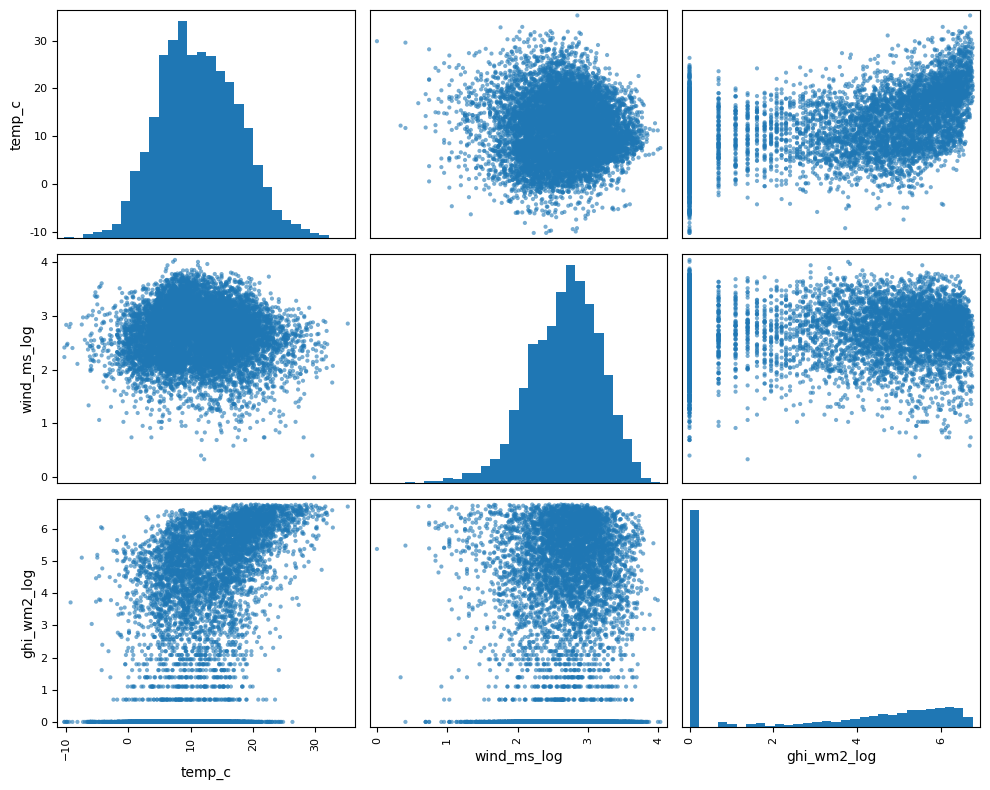

Correlation insights:
Temperature vs Wind Speed: -0.038
Temperature vs Solar Radiation: 0.478
Wind Speed vs Solar Radiation: 0.062


In [15]:
# Correlation analysis
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Correlation matrix of weather variables
weather_vars = ['temp_c', 'wind_ms_log', 'ghi_wm2_log']
corr_matrix = df_sample[weather_vars].corr()

# Create heatmap using matplotlib
im = axes[0].imshow(corr_matrix.values, cmap='coolwarm', vmin=-1, vmax=1)
axes[0].set_xticks(range(len(corr_matrix.columns)))
axes[0].set_yticks(range(len(corr_matrix.index)))
axes[0].set_xticklabels(corr_matrix.columns, rotation=45)
axes[0].set_yticklabels(corr_matrix.index)
axes[0].set_title('Weather Variables Correlation')

# Add correlation values as text
for i in range(len(corr_matrix.index)):
    for j in range(len(corr_matrix.columns)):
        text = axes[0].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                           ha="center", va="center", color="black", fontweight='bold')


# Scatter plot matrix
from pandas.plotting import scatter_matrix
scatter_matrix(df_sample[weather_vars], alpha=0.6, ax=axes[1], diagonal='hist', hist_kwds={'bins':30})
axes[1].set_title('Weather Variables Scatter Matrix')

plt.tight_layout()
plt.show()

print("Correlation insights:")
print(f"Temperature vs Wind Speed: {corr_matrix.loc['temp_c', 'wind_ms_log']:.3f}")
print(f"Temperature vs Solar Radiation: {corr_matrix.loc['temp_c', 'ghi_wm2_log']:.3f}")
print(f"Wind Speed vs Solar Radiation: {corr_matrix.loc['wind_ms_log', 'ghi_wm2_log']:.3f}")


## Model Training

Now let's train different conditional mixture models to understand how weather variables depend on time patterns.


In [16]:
# Use full dataset for training and analysis
X_train, y_train = X, y

print(f"Full dataset: {X_train.shape[0]} samples")
print(f"Training period: {df_clean.iloc[0]['datetime']} to {df_clean.iloc[-1]['datetime']}")
print("Using full dataset for both training and visualization to avoid artifacts from small test sets")


Full dataset: 52608 samples
Training period: 2019-01-01 00:00:00 to 2024-12-31 23:00:00
Using full dataset for both training and visualization to avoid artifacts from small test sets


In [17]:
# Train different models with better hyperparameters
n_components = 10

# Try different configurations to fix the issues
models = {
    'ConditionalGMM': ConditionalGMMRegressor(n_components=n_components, random_state=42, max_iter=200),
    'MixtureOfExperts': MixtureOfExpertsRegressor(
        n_components=n_components, 
        random_state=42, 
        max_iter=200,
        gating_max_iter=100,
        gating_tol=1e-4
    ),
    'Discriminative': DiscriminativeConditionalGMMRegressor(
        n_components=n_components, 
        random_state=42,
        max_iter=200,
        tol=1e-8,  # Much stricter tolerance to force more iterations
        weight_step=0.01  # Smaller step size for more stable convergence
    )
}

print("Training models...")
failed_models = []
for name, model in models.items():
    print(f"  Training {name}...")
    try:
        model.fit(X_train, y_train)
        
        # Check if model converged
        if hasattr(model, 'converged_'):
            print(f"    Converged: {model.converged_}")
        if hasattr(model, 'n_iter_'):
            print(f"    Iterations: {model.n_iter_}")
        
        # Evaluate performance on full dataset
        y_pred = model.predict(X_train)
        mse = mean_squared_error(y_train, y_pred)
        r2 = r2_score(y_train, y_pred)
        log_likelihood = model.score(X_train, y_train)
        
        # Check for NaN or infinite values
        nan_pred = np.isnan(y_pred).sum()
        inf_pred = np.isinf(y_pred).sum()
        nan_ll = np.isnan(log_likelihood) or np.isinf(log_likelihood)
        
        print(f"    MSE: {mse:.4f}, R²: {r2:.4f}, Log-likelihood: {log_likelihood:.4f}")
        if nan_pred > 0:
            print(f"    WARNING: {nan_pred} NaN predictions!")
        if inf_pred > 0:
            print(f"    WARNING: {inf_pred} infinite predictions!")
        if nan_ll:
            print(f"    WARNING: Invalid log-likelihood!")
            
        # Check prediction ranges
        print(f"    Prediction range: [{y_pred.min():.3f}, {y_pred.max():.3f}]")
        print(f"    Target range: [{y_train.min():.3f}, {y_train.max():.3f}]")
        
    except Exception as e:
        print(f"    ERROR: {e}")
        # Mark for removal
        failed_models.append(name)

# Remove failed models after iteration
for name in failed_models:
    del models[name]

print(f"\nTraining completed! {len(models)} models successful.")


Training models...
  Training ConditionalGMM...
    Converged: True
    Iterations: 48
    MSE: 3.8298, R²: 0.5931, Log-likelihood: -0.9067
    Prediction range: [-0.031, 22.637]
    Target range: [-10.300, 38.000]
  Training MixtureOfExperts...
    Converged: True
    Iterations: 34
    MSE: 5.8303, R²: 0.4625, Log-likelihood: -1.6831
    Prediction range: [-1.514, 21.341]
    Target range: [-10.300, 38.000]
  Training Discriminative...
    Converged: False
    Iterations: 200
    MSE: 3.7619, R²: 0.5954, Log-likelihood: -1.0527
    Prediction range: [-0.059, 22.603]
    Target range: [-10.300, 38.000]

Training completed! 3 models successful.


In [18]:
# Diagnostic analysis of model behavior
print("=== DIAGNOSTIC ANALYSIS ===")
print(f"Data shape: X={X_train.shape}, y={y_train.shape}")
print(f"X range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"y range: [{y_train.min():.3f}, {y_train.max():.3f}]")
print(f"X std: {X_train.std():.3f}")
print(f"y std: {y_train.std():.3f}")

# Check for any issues with the data
print(f"\nData quality checks:")
print(f"X has NaN: {np.isnan(X_train).any()}")
print(f"y has NaN: {np.isnan(y_train).any()}")
print(f"X has Inf: {np.isinf(X_train).any()}")
print(f"y has Inf: {np.isinf(y_train).any()}")

# Test each model with a small sample
print(f"\nTesting models with small sample:")
if False:
    test_idx = np.random.choice(len(X_train), 10_000, replace=False)
    X_test_small = X_train[test_idx]
    y_test_small = y_train[test_idx]
else:
    X_test_small = X_train
    y_test_small = y_train

# Create a list of model names to avoid dictionary modification during iteration
model_names = list(models.keys())

for name in model_names:
    if name not in models:  # Skip if model was removed
        continue
        
    print(f"\n{name}:")
    try:
        model = models[name]
        
        # Test prediction
        y_pred_small = model.predict(X_test_small)
        print(f"  Prediction shape: {y_pred_small.shape}")
        print(f"  Prediction range: [{y_pred_small.min():.3f}, {y_pred_small.max():.3f}]")
        
        # Test sampling
        samples = model.sample(X_test_small[:5], n_samples=3)
        print(f"  Sample shape: {samples.shape}")
        print(f"  Sample range: [{samples.min():.3f}, {samples.max():.3f}]")
        
        # Test log_prob
        log_probs = model.log_prob(X_test_small[:5], y_test_small[:5])
        print(f"  Log prob shape: {log_probs.shape}")
        print(f"  Log prob range: [{log_probs.min():.3f}, {log_probs.max():.3f}]")
        
        # Test log-likelihood (score method)
        log_likelihood = model.score(X_test_small, y_test_small)
        print(f"  Log-likelihood: {log_likelihood:.4f}")
        
        # Check for NaN or infinite values in log-likelihood
        if np.isnan(log_likelihood) or np.isinf(log_likelihood):
            print(f"  WARNING: Invalid log-likelihood!")
        
    except Exception as e:
        print(f"  ERROR: {e}")

print("\n=== END DIAGNOSTIC ===")


=== DIAGNOSTIC ANALYSIS ===
Data shape: X=(52608, 4), y=(52608, 3)
X range: [-1.000, 1.000]
y range: [-10.300, 38.000]
X std: 0.707
y std: 5.714

Data quality checks:
X has NaN: False
y has NaN: False
X has Inf: False
y has Inf: False

Testing models with small sample:

ConditionalGMM:
  Prediction shape: (52608, 3)
  Prediction range: [-0.031, 22.637]
  Sample shape: (5, 3, 3)
  Sample range: [-1.880, 14.501]
  Log prob shape: (5,)
  Log prob range: [3.369, 3.383]
  Log-likelihood: -0.9067

MixtureOfExperts:
  Prediction shape: (52608, 3)
  Prediction range: [-1.514, 21.341]
  Sample shape: (5, 3, 3)
  Sample range: [-13.984, 9.041]
  Log prob shape: (5,)
  Log prob range: [1.896, 1.997]
  Log-likelihood: -1.6831

Discriminative:
  Prediction shape: (52608, 3)
  Prediction range: [-0.059, 22.603]
  Sample shape: (5, 3, 3)
  Sample range: [-2.767, 11.590]
  Log prob shape: (5,)
  Log prob range: [3.234, 3.249]
  Log-likelihood: -1.0527

=== END DIAGNOSTIC ===


## Model Analysis and Visualization

Let's analyze how well our models capture the weather patterns and create visualizations of the learned distributions.


Model Performance Comparison:
              Model     MSE      R²  Log-Likelihood
0    ConditionalGMM  3.8298  0.5931         -0.9067
1  MixtureOfExperts  5.8303  0.4625         -1.6831
2    Discriminative  3.7619  0.5954         -1.0527


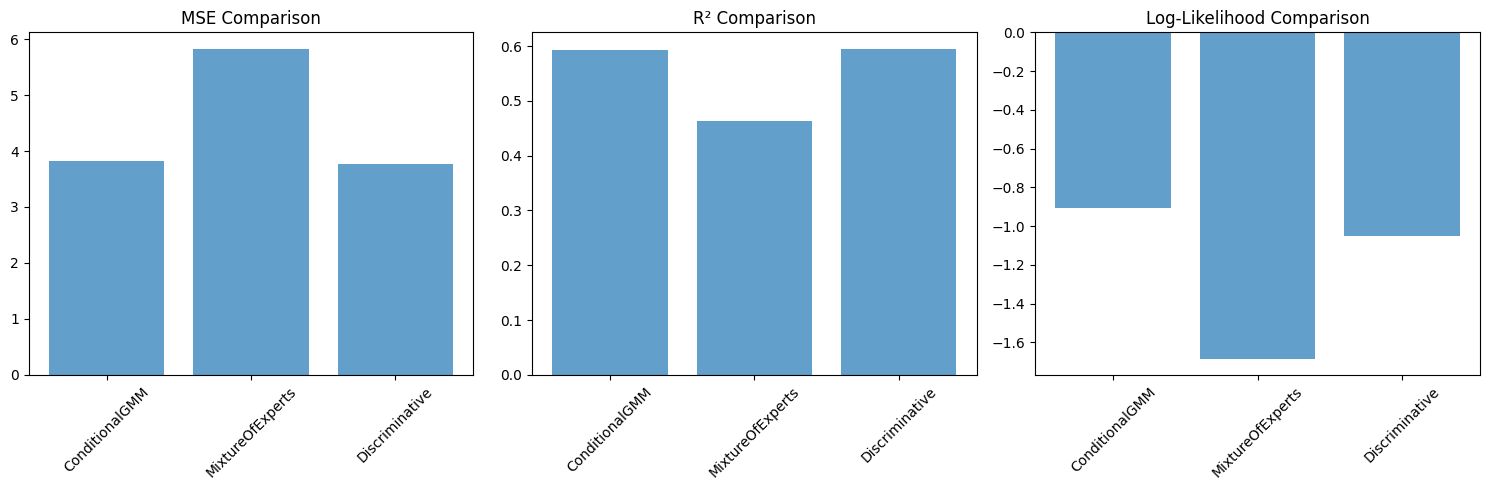

In [19]:
# Compare model performance
results = []
for name, model in models.items():
    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    log_likelihood = model.score(X_train, y_train)
    
    results.append({
        'Model': name,
        'MSE': mse,
        'R²': r2,
        'Log-Likelihood': log_likelihood
    })

results_df = pd.DataFrame(results)
print("Model Performance Comparison:")
print(results_df.round(4))

# Visualize performance
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['MSE', 'R²', 'Log-Likelihood']
for i, metric in enumerate(metrics):
    axes[i].bar(results_df['Model'], results_df[metric], alpha=0.7)
    axes[i].set_title(f'{metric} Comparison')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Best model: ConditionalGMM


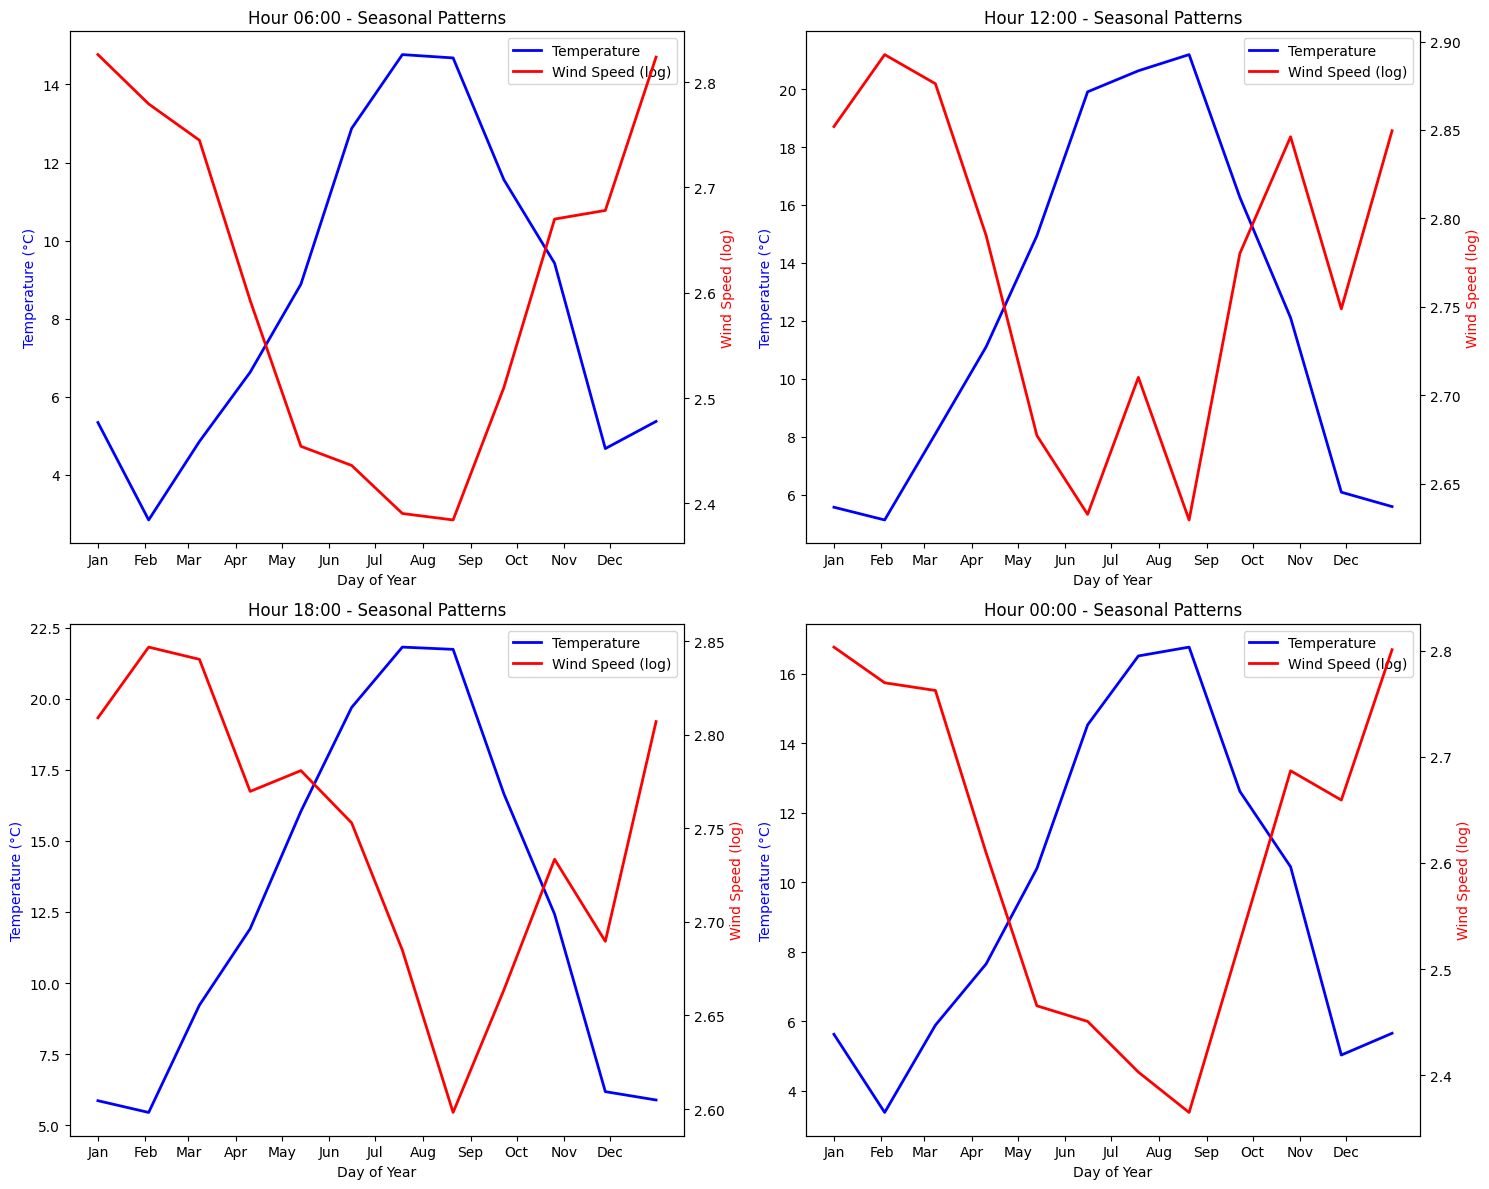

In [20]:
# Analyze seasonal patterns using the best model
best_model_name = results_df.loc[results_df['Log-Likelihood'].idxmax(), 'Model']
best_model = models[best_model_name]
print(f"Best model: {best_model_name}")

# Create a grid of time points for analysis
days_of_year = np.linspace(1, 365, 12)  # 12 points per year
hours_of_day = [6, 12, 18, 0]  # Dawn, noon, dusk, midnight

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, hour in enumerate(hours_of_day):
    # Create conditioning variables for this time
    X_condition = np.zeros((len(days_of_year), 4))
    X_condition[:, 0] = np.sin(2 * np.pi * days_of_year / 365.25)  # annual_sin
    X_condition[:, 1] = np.cos(2 * np.pi * days_of_year / 365.25)  # annual_cos
    X_condition[:, 2] = np.sin(2 * np.pi * hour / 24)  # daily_sin
    X_condition[:, 3] = np.cos(2 * np.pi * hour / 24)  # daily_cos
    
    # Get predictions
    y_pred = best_model.predict(X_condition)
    
    # Plot temperature and wind speed
    ax = axes[i]
    ax2 = ax.twinx()
    
    line1 = ax.plot(days_of_year, y_pred[:, 0], 'b-', linewidth=2, label='Temperature')
    line2 = ax2.plot(days_of_year, y_pred[:, 1], 'r-', linewidth=2, label='Wind Speed (log)')
    
    ax.set_xlabel('Day of Year')
    ax.set_ylabel('Temperature (°C)', color='b')
    ax2.set_ylabel('Wind Speed (log)', color='r')
    ax.set_title(f'Hour {hour:02d}:00 - Seasonal Patterns')
    
    # Add month labels
    month_days = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticks(month_days)
    ax.set_xticklabels(month_names)
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()


In [21]:
# Analyze joint densities at specific time points
time_points = [
    ('Winter Solstice (Dec 21, 12:00)', 355, 12),  # Winter noon
    ('Spring Equinox (Mar 21, 12:00)', 80, 12),    # Spring noon
    ('Summer Solstice (Jun 21, 12:00)', 172, 12),  # Summer noon
    ('Autumn Equinox (Sep 21, 12:00)', 264, 12)   # Autumn noon
]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (title, day_of_year, hour) in enumerate(time_points):
    # Create conditioning variables
    X_condition = np.array([[
        np.sin(2 * np.pi * day_of_year / 365.25),  # annual_sin
        np.cos(2 * np.pi * day_of_year / 365.25),  # annual_cos
        np.sin(2 * np.pi * hour / 24),             # daily_sin
        np.cos(2 * np.pi * hour / 24)              # daily_cos
    ]])
    
    # Get conditional mixture
    gmm = best_model.condition(X_condition)
    
    # Generate samples from the conditional distribution
    n_samples = 1000
    samples = gmm.sample(n_samples)[0]  # (n_samples, 3)
    
    # Create a grid for density calculation
    temp_range = np.linspace(samples[:, 0].min() - 2, samples[:, 0].max() + 2, 50)
    wind_range = np.linspace(samples[:, 1].min() - 0.5, samples[:, 1].max() + 0.5, 50)
    temp_grid, wind_grid = np.meshgrid(temp_range, wind_range)
    
    # Calculate density for each grid point
    grid_points = np.column_stack([temp_grid.ravel(), wind_grid.ravel()])
    
    # Create dummy solar radiation values for the grid (we'll use the mean)
    solar_mean = samples[:, 2].mean()
    grid_solar = np.full((grid_points.shape[0],), solar_mean)
    
    # Calculate log probabilities
    log_probs = gmm.score_samples(np.column_stack([grid_points, grid_solar.reshape(-1, 1)]))
    density = np.exp(log_probs).reshape(temp_grid.shape)
    
    # Plot temperature vs wind speed
    ax = axes[i]
    
    # Plot density contours
    contour = ax.contour(temp_grid, wind_grid, density, levels=8, alpha=0.7, colors='black', linewidths=1)
    ax.clabel(contour, inline=True, fontsize=8, fmt='%.3f')
    
    # Plot samples with solar radiation color
    scatter = ax.scatter(samples[:, 0], samples[:, 1], alpha=0.6, s=20, c=samples[:, 2], 
                        cmap='viridis', label='Solar Radiation (log)')
    
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Wind Speed (log)')
    ax.set_title(f'{title}\nTemperature vs Wind Speed (with PDF contours)')
    
    # Add colorbar for solar radiation
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Solar Radiation (log)')
    
    # Add some statistics
    temp_mean = samples[:, 0].mean()
    wind_mean = samples[:, 1].mean()
    ax.text(0.05, 0.95, f'Mean Temp: {temp_mean:.1f}°C\nMean Wind: {wind_mean:.2f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


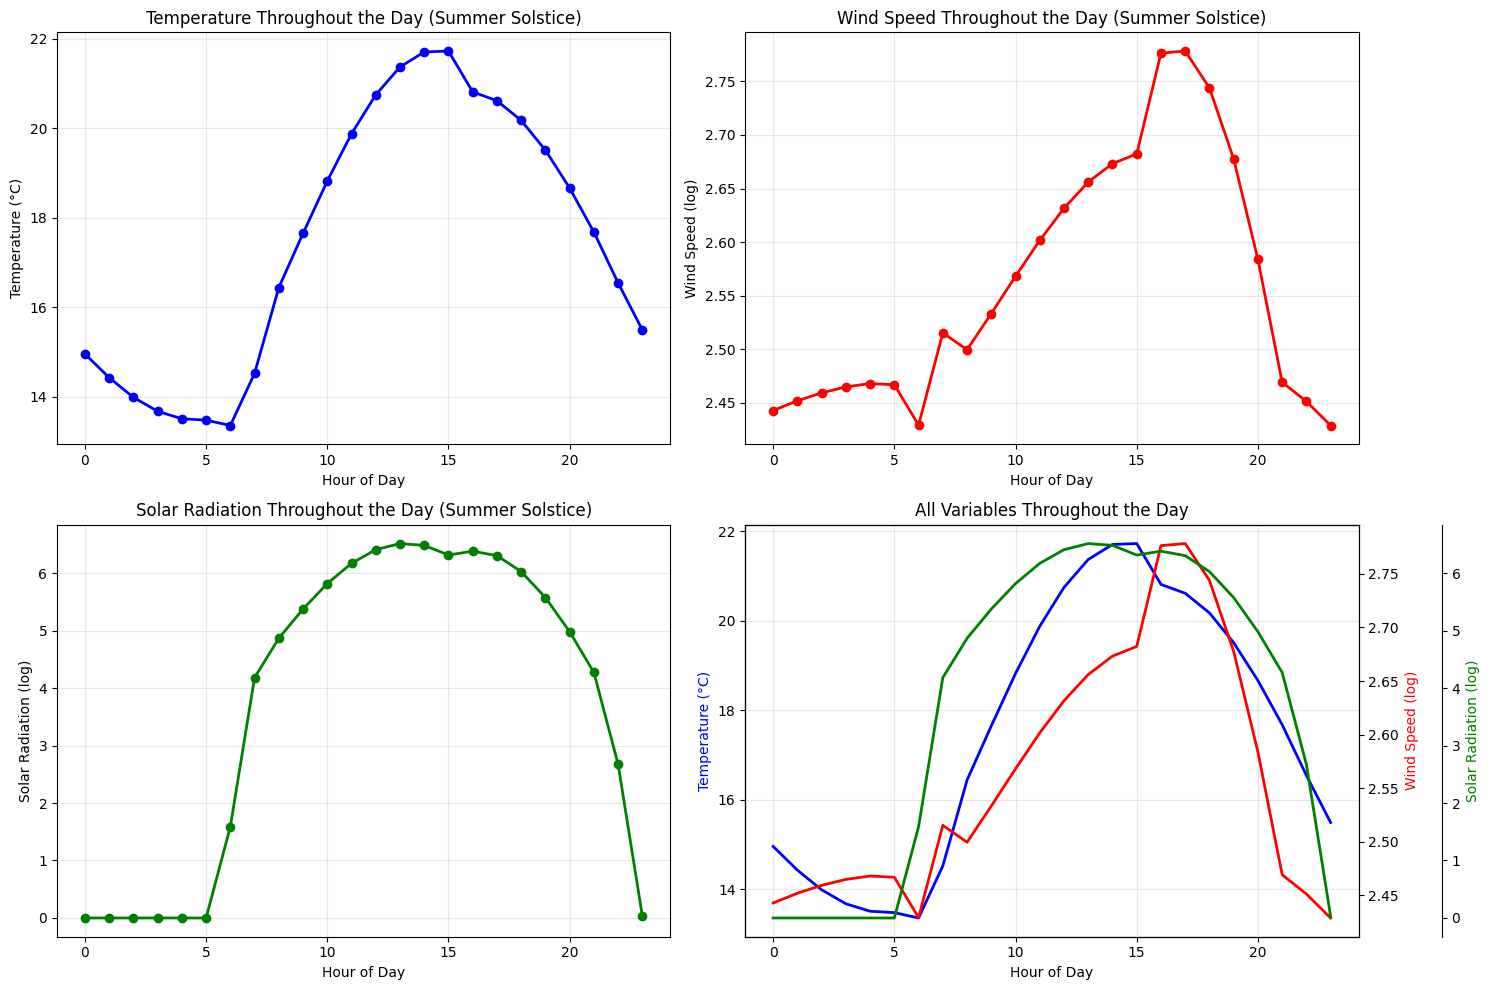

In [22]:
# Analyze diurnal patterns (daily cycles)
hours = np.arange(0, 24)
day_of_year = 172  # Summer solstice

# Create conditioning variables for each hour
X_condition = np.zeros((24, 4))
X_condition[:, 0] = np.sin(2 * np.pi * day_of_year / 365.25)  # annual_sin
X_condition[:, 1] = np.cos(2 * np.pi * day_of_year / 365.25)  # annual_cos
X_condition[:, 2] = np.sin(2 * np.pi * hours / 24)  # daily_sin
X_condition[:, 3] = np.cos(2 * np.pi * hours / 24)  # daily_cos

# Get predictions
y_pred = best_model.predict(X_condition)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Temperature throughout the day
axes[0, 0].plot(hours, y_pred[:, 0], 'b-', linewidth=2, marker='o')
axes[0, 0].set_title('Temperature Throughout the Day (Summer Solstice)')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].grid(True, alpha=0.3)

# Wind speed throughout the day
axes[0, 1].plot(hours, y_pred[:, 1], 'r-', linewidth=2, marker='o')
axes[0, 1].set_title('Wind Speed Throughout the Day (Summer Solstice)')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Wind Speed (log)')
axes[0, 1].grid(True, alpha=0.3)

# Solar radiation throughout the day
axes[1, 0].plot(hours, y_pred[:, 2], 'g-', linewidth=2, marker='o')
axes[1, 0].set_title('Solar Radiation Throughout the Day (Summer Solstice)')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Solar Radiation (log)')
axes[1, 0].grid(True, alpha=0.3)

# All variables together
ax = axes[1, 1]
ax2 = ax.twinx()
ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 60))

line1 = ax.plot(hours, y_pred[:, 0], 'b-', linewidth=2, label='Temperature')
line2 = ax2.plot(hours, y_pred[:, 1], 'r-', linewidth=2, label='Wind Speed')
line3 = ax3.plot(hours, y_pred[:, 2], 'g-', linewidth=2, label='Solar Radiation')

ax.set_xlabel('Hour of Day')
ax.set_ylabel('Temperature (°C)', color='b')
ax2.set_ylabel('Wind Speed (log)', color='r')
ax3.set_ylabel('Solar Radiation (log)', color='g')
ax.set_title('All Variables Throughout the Day')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== 2024 DAILY AVERAGE ANALYSIS (FULL DATASET TRAINING) ===

Computing daily averages from FULL dataset...
Full dataset daily averages shape: (2192, 3)
Date range: 2019-01-01 to 2024-12-31

Creating daily conditioning variables (annual/seasonal only)...
Daily conditioning variables shape: (2192, 2)
Daily target variables shape: (2192, 3)

Training models on FULL daily dataset...
  Training ConditionalGMM on full daily data...
    MSE: 2.7648, R²: 0.6022, Log-likelihood: -2.6536
  Training MixtureOfExperts on full daily data...
    MSE: 3.1324, R²: 0.5783, Log-likelihood: -2.5658
  Training Discriminative on full daily data...
    MSE: 2.7416, R²: 0.6030, Log-likelihood: -2.6441

Filtering for 2024 data...
2024 data points: 8784
2024 daily averages shape: (366, 3)
2024 daily conditioning variables shape: (366, 2)
2024 daily target variables shape: (366, 3)

Generating samples for 2024...
  Generating samples for ConditionalGMM...
    Sample shape: (366, 100, 3)
  Generating samples for 

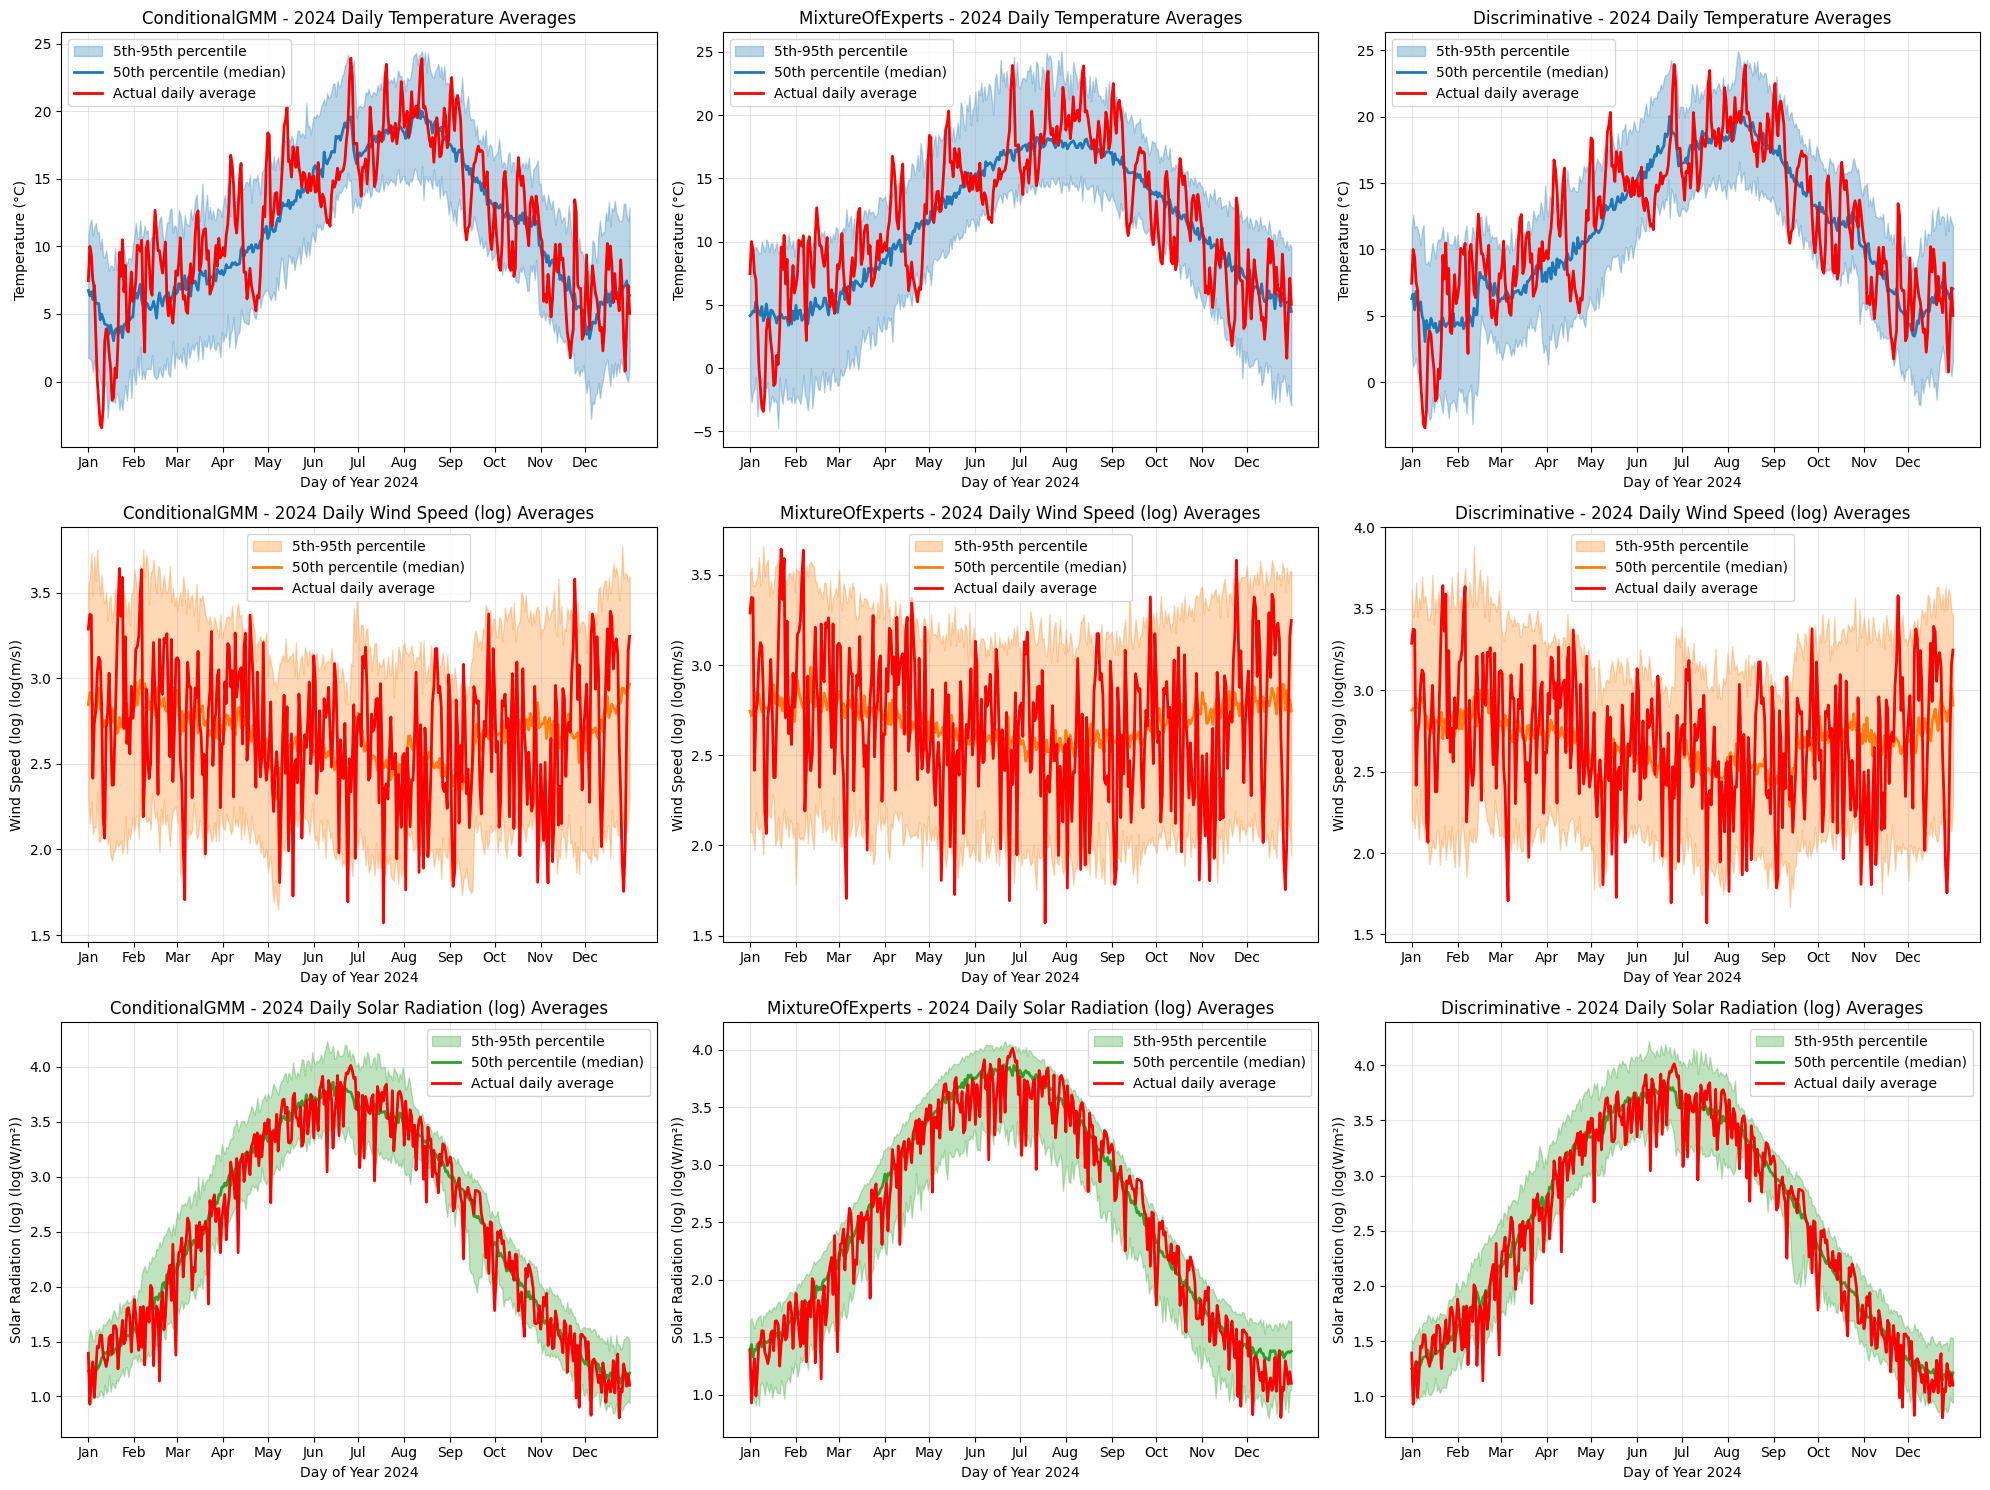


2024 Daily Statistics:

Temperature:
  Actual daily average - Min: -3.43°C, Max: 23.92°C, Mean: 11.72°C
  ConditionalGMM simulated daily average - Min: -6.78°C, Max: 28.61°C, Mean: 11.31°C
  MixtureOfExperts simulated daily average - Min: -9.65°C, Max: 30.93°C, Mean: 11.14°C
  Discriminative simulated daily average - Min: -8.63°C, Max: 28.49°C, Mean: 11.30°C

Wind Speed (log):
  Actual daily average - Min: 1.57log(m/s), Max: 3.64log(m/s), Mean: 2.68log(m/s)
  ConditionalGMM simulated daily average - Min: 1.04log(m/s), Max: 4.54log(m/s), Mean: 2.67log(m/s)
  MixtureOfExperts simulated daily average - Min: 1.05log(m/s), Max: 4.06log(m/s), Mean: 2.68log(m/s)
  Discriminative simulated daily average - Min: 1.00log(m/s), Max: 4.34log(m/s), Mean: 2.68log(m/s)

Solar Radiation (log):
  Actual daily average - Min: 0.81log(W/m²), Max: 4.01log(W/m²), Mean: 2.53log(W/m²)
  ConditionalGMM simulated daily average - Min: 0.55log(W/m²), Max: 4.54log(W/m²), Mean: 2.55log(W/m²)
  MixtureOfExperts simu

In [23]:
# Analyze 2024 data with daily averages and percentiles - FULL DATASET TRAINING
print("=== 2024 DAILY AVERAGE ANALYSIS (FULL DATASET TRAINING) ===")

# First compute daily averages from the FULL dataset
print("\nComputing daily averages from FULL dataset...")
df_clean['date'] = df_clean['datetime'].dt.date

# Get daily averages for all data
all_daily = df_clean.groupby('date')[targets].mean()
print(f"Full dataset daily averages shape: {all_daily.shape}")
print(f"Date range: {all_daily.index.min()} to {all_daily.index.max()}")

# Create daily conditioning variables for all data (only annual/seasonal features)
print("\nCreating daily conditioning variables (annual/seasonal only)...")
daily_conditioning = []
daily_dates = []

for date in all_daily.index:
    # Use day of year for seasonal patterns (daily sin/cos not needed for daily averages)
    day_of_year = date.timetuple().tm_yday
    
    # Create conditioning variables for this day (only annual/seasonal features)
    X_day = np.array([[
        np.sin(2 * np.pi * day_of_year / 365.25),  # annual_sin
        np.cos(2 * np.pi * day_of_year / 365.25)   # annual_cos
    ]])
    daily_conditioning.append(X_day[0])
    daily_dates.append(date)

X_daily_all = np.array(daily_conditioning)  # (n_days, 2)
y_daily_all = all_daily.values  # (n_days, 3)

print(f"Daily conditioning variables shape: {X_daily_all.shape}")
print(f"Daily target variables shape: {y_daily_all.shape}")

# Train models on FULL daily dataset
print("\nTraining models on FULL daily dataset...")
daily_models = {}

for name, model_class in [
    ('ConditionalGMM', ConditionalGMMRegressor),
    ('MixtureOfExperts', MixtureOfExpertsRegressor),
    ('Discriminative', DiscriminativeConditionalGMMRegressor)
]:
    print(f"  Training {name} on full daily data...")
    
    if name == 'ConditionalGMM':
        daily_model = ConditionalGMMRegressor(n_components=10, random_state=42, max_iter=200)
    elif name == 'MixtureOfExperts':
        daily_model = MixtureOfExpertsRegressor(
            n_components=10, 
            random_state=42, 
            max_iter=200,
            gating_max_iter=100,
            gating_tol=1e-4
        )
    else:  # Discriminative
        daily_model = DiscriminativeConditionalGMMRegressor(
            n_components=10, 
            random_state=42,
            max_iter=200,
            tol=1e-8,
            weight_step=0.01
        )
    
    try:
        daily_model.fit(X_daily_all, y_daily_all)
        daily_models[name] = daily_model
        
        # Evaluate performance on full dataset
        y_pred = daily_model.predict(X_daily_all)
        mse = mean_squared_error(y_daily_all, y_pred)
        r2 = r2_score(y_daily_all, y_pred)
        log_likelihood = daily_model.score(X_daily_all, y_daily_all)
        
        print(f"    MSE: {mse:.4f}, R²: {r2:.4f}, Log-likelihood: {log_likelihood:.4f}")
        
    except Exception as e:
        print(f"    ERROR: {e}")

# Filter for 2024 data only
print(f"\nFiltering for 2024 data...")
df_2024 = df_clean[df_clean['year'] == 2024].copy()
print(f"2024 data points: {len(df_2024)}")

if len(df_2024) > 0:
    # Get 2024 daily averages
    df_2024['date'] = df_2024['datetime'].dt.date
    actual_daily_2024 = df_2024.groupby('date')[targets].mean()
    print(f"2024 daily averages shape: {actual_daily_2024.shape}")
    
    # Create 2024 conditioning variables (only annual/seasonal features)
    daily_conditioning_2024 = []
    daily_dates_2024 = []
    
    for date in actual_daily_2024.index:
        day_of_year = date.timetuple().tm_yday
        
        X_day = np.array([[
            np.sin(2 * np.pi * day_of_year / 365.25),  # annual_sin
            np.cos(2 * np.pi * day_of_year / 365.25)   # annual_cos
        ]])
        daily_conditioning_2024.append(X_day[0])
        daily_dates_2024.append(date)
    
    X_daily_2024 = np.array(daily_conditioning_2024)  # (n_days_2024, 2)
    y_daily_2024 = actual_daily_2024.values  # (n_days_2024, 3)
    
    print(f"2024 daily conditioning variables shape: {X_daily_2024.shape}")
    print(f"2024 daily target variables shape: {y_daily_2024.shape}")
    
    # Generate samples for 2024 only
    print(f"\nGenerating samples for 2024...")
    n_samples_per_day = 100
    
    daily_samples = {}
    for name, daily_model in daily_models.items():
        print(f"  Generating samples for {name}...")
        samples = daily_model.sample(X_daily_2024, n_samples=n_samples_per_day)  # (n_days_2024, n_samples, 3)
        daily_samples[name] = samples
        print(f"    Sample shape: {samples.shape}")
    
    # Plot daily averages with percentiles for all three variables
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    
    variable_names = ['Temperature', 'Wind Speed (log)', 'Solar Radiation (log)']
    variable_units = ['°C', 'log(m/s)', 'log(W/m²)']
    variable_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    
    for i, (name, daily_samps) in enumerate(daily_samples.items()):
        for var_idx in range(3):  # Temperature, Wind Speed, Solar Radiation
            ax = axes[var_idx, i]
            
            # Get samples for current variable
            var_samples = daily_samps[:, :, var_idx]  # (n_days, n_samples)
            
            # Remove NaN days
            valid_days = ~np.isnan(var_samples).all(axis=1)
            var_samples_clean = var_samples[valid_days]
            actual_var_clean = y_daily_2024[valid_days, var_idx]
            dates_clean = [daily_dates_2024[j] for j in range(len(daily_dates_2024)) if valid_days[j]]
            
            if len(var_samples_clean) > 0:
                # Calculate percentiles
                p5 = np.percentile(var_samples_clean, 5, axis=1)
                p50 = np.percentile(var_samples_clean, 50, axis=1)
                p95 = np.percentile(var_samples_clean, 95, axis=1)
                
                # Plot
                ax.fill_between(range(len(dates_clean)), p5, p95, alpha=0.3, 
                               color=variable_colors[var_idx], label='5th-95th percentile')
                ax.plot(range(len(dates_clean)), p50, color=variable_colors[var_idx], 
                       linewidth=2, label='50th percentile (median)')
                ax.plot(range(len(dates_clean)), actual_var_clean, 'r-', linewidth=2, 
                       label='Actual daily average')
                
                ax.set_title(f'{name} - 2024 Daily {variable_names[var_idx]} Averages')
                ax.set_xlabel('Day of Year 2024')
                ax.set_ylabel(f'{variable_names[var_idx]} ({variable_units[var_idx]})')
                ax.legend()
                ax.grid(True, alpha=0.3)
                
                # Set x-axis labels to show months
                n_days = len(dates_clean)
                if n_days > 0:
                    # Add month markers
                    month_starts = [0]  # January 1st
                    month_names = ['Jan']
                    for month in range(2, 13):
                        # Find first day of each month
                        month_dates = [d for d in dates_clean if d.month == month]
                        if month_dates:
                            month_idx = list(dates_clean).index(month_dates[0])
                            month_starts.append(month_idx)
                            month_names.append(dates_clean[month_idx].strftime('%b'))
                    
                    ax.set_xticks(month_starts)
                    ax.set_xticklabels(month_names)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics for all three variables
    print(f"\n2024 Daily Statistics:")
    for var_idx, var_name in enumerate(variable_names):
        print(f"\n{var_name}:")
        print(f"  Actual daily average - Min: {y_daily_2024[:, var_idx].min():.2f}{variable_units[var_idx]}, "
              f"Max: {y_daily_2024[:, var_idx].max():.2f}{variable_units[var_idx]}, "
              f"Mean: {y_daily_2024[:, var_idx].mean():.2f}{variable_units[var_idx]}")
        
        for name, daily_samps in daily_samples.items():
            var_samples = daily_samps[:, :, var_idx]
            valid_days = ~np.isnan(var_samples).all(axis=1)
            if valid_days.any():
                var_clean = var_samples[valid_days]
                print(f"  {name} simulated daily average - "
                      f"Min: {var_clean.min():.2f}{variable_units[var_idx]}, "
                      f"Max: {var_clean.max():.2f}{variable_units[var_idx]}, "
                      f"Mean: {var_clean.mean():.2f}{variable_units[var_idx]}")

else:
    print("No 2024 data available in the dataset")


In [24]:
print("=== 2024 ANALYSIS (SELECTING FROM FULL DATASET) ===")

n_components = 4

# First compute daily averages from the FULL dataset
print("\nComputing daily averages from FULL dataset...")
df_clean['date'] = df_clean['datetime'].dt.date

# Get daily averages for all data
all_daily = df_clean.groupby('date')[targets].mean()
print(f"Full dataset daily averages shape: {all_daily.shape}")
print(f"Date range: {all_daily.index.min()} to {all_daily.index.max()}")

# Create daily conditioning variables for all data (only annual/seasonal features)
print("\nCreating daily conditioning variables (annual/seasonal only)...")
daily_conditioning = []
daily_dates = []

for date in all_daily.index:
    # Use day of year for seasonal patterns (daily sin/cos not needed for daily averages)
    day_of_year = date.timetuple().tm_yday
    
    # Create conditioning variables for this day (only annual/seasonal features)
    X_day = np.array([[
        np.sin(2 * np.pi * day_of_year / 365.25),  # annual_sin
        np.cos(2 * np.pi * day_of_year / 365.25)   # annual_cos
    ]])
    daily_conditioning.append(X_day[0])
    daily_dates.append(date)

X_daily_all = np.array(daily_conditioning)  # (n_days, 2)
y_daily_all = all_daily.values  # (n_days, 3)

print(f"Daily conditioning variables shape: {X_daily_all.shape}")
print(f"Daily target variables shape: {y_daily_all.shape}")

# Train models on FULL daily dataset
print("\nTraining models on FULL daily dataset...")
daily_models = {}

for name, model_class in [
    ('ConditionalGMM', ConditionalGMMRegressor),
    ('MixtureOfExperts', MixtureOfExpertsRegressor),
    ('Discriminative', DiscriminativeConditionalGMMRegressor)
]:
    print(f"  Training {name} on full daily data...")
    
    if name == 'ConditionalGMM':
        daily_model = ConditionalGMMRegressor(n_components=n_components, random_state=42)
    elif name == 'MixtureOfExperts':
        daily_model = MixtureOfExpertsRegressor(n_components=n_components, random_state=42)
    else:  # Discriminative
        daily_model = DiscriminativeConditionalGMMRegressor(n_components=n_components, random_state=42)
    
    try:
        daily_model.fit(X_daily_all, y_daily_all)
        daily_models[name] = daily_model
        
        # Evaluate performance on full dataset
        y_pred = daily_model.predict(X_daily_all)
        mse = mean_squared_error(y_daily_all, y_pred)
        r2 = r2_score(y_daily_all, y_pred)
        log_likelihood = daily_model.score(X_daily_all, y_daily_all)
        
        print(f"    MSE: {mse:.4f}, R²: {r2:.4f}, Log-likelihood: {log_likelihood:.4f}")
        
    except Exception as e:
        print(f"    ERROR: {e}")

# Select 2024 data from full dataset
print(f"\nSelecting 2024 data from full dataset...")

# Simple boolean filter for 2024 dates
is_2024 = [date.year == 2024 for date in all_daily.index]
X_daily_2024 = X_daily_all[is_2024]
y_daily_2024 = y_daily_all[is_2024]

print(f"2024 daily conditioning variables shape: {X_daily_2024.shape}")
print(f"2024 daily target variables shape: {y_daily_2024.shape}")


# Generate samples for 2024 only
print(f"\nGenerating samples for 2024...")
n_samples_per_day = 100

daily_samples = {}
for name, daily_model in daily_models.items():
    print(f"  Generating samples for {name}...")
    
    # Generate samples with different random states to ensure independence
    samples_list = []
    for i in range(len(X_daily_2024)):
        # Use different random state for each day to ensure independence
        day_samples = daily_model.sample(X_daily_2024[i:i+1], n_samples=n_samples_per_day)
        print(f"    Day {i}: day_samples.shape = {day_samples.shape}")
        
        # Handle both 2D and 3D return shapes
        if day_samples.ndim == 3:
            # Expected: (1, n_samples, 3) -> take [0] to get (n_samples, 3)
            samples_list.append(day_samples[0])
        elif day_samples.ndim == 2:
            # Actual: (n_samples, 3) -> use directly
            samples_list.append(day_samples)
        else:
            print(f"    ERROR: Expected 2D or 3D array, got {day_samples.ndim}D")
            print(f"    day_samples.shape = {day_samples.shape}")
            raise ValueError(f"Unexpected shape from sample(): {day_samples.shape}")
    
    samples = np.array(samples_list)  # (n_days_2024, n_samples, 3)
    daily_samples[name] = samples
    print(f"    Final sample shape: {samples.shape}")
    print(f"    Expected shape: ({len(X_daily_2024)}, {n_samples_per_day}, 3)")
    
    if samples.shape != (len(X_daily_2024), n_samples_per_day, 3):
        raise ValueError(f"Final samples shape {samples.shape} != expected {(len(X_daily_2024), n_samples_per_day, 3)}")

# Plot daily averages with percentiles for all three variables
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

variable_names = ['Temperature', 'Wind Speed (log)', 'Solar Radiation (log)']
variable_units = ['°C', 'log(m/s)', 'log(W/m²)']
variable_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

for i, (name, daily_samps) in enumerate(daily_samples.items()):
    for var_idx in range(3):  # Temperature, Wind Speed, Solar Radiation
        ax = axes[var_idx, i]
        
        # Get samples for current variable
        var_samples = daily_samps[:, :, var_idx]  # (n_days, n_samples)
        
        # Remove NaN days
        valid_days = ~np.isnan(var_samples).all(axis=1)
        var_samples_clean = var_samples[valid_days]
        actual_var_clean = y_daily_2024[valid_days, var_idx]
        dates_clean = [daily_dates_2024[j] for j in range(len(daily_dates_2024)) if valid_days[j]]
        
        if len(var_samples_clean) > 0:
            # Calculate percentiles
            p5 = np.percentile(var_samples_clean, 5, axis=1)
            p50 = np.percentile(var_samples_clean, 50, axis=1)
            p95 = np.percentile(var_samples_clean, 95, axis=1)
            
            # Plot
            ax.fill_between(range(len(dates_clean)), p5, p95, alpha=0.3, 
                            color=variable_colors[var_idx], label='5th-95th percentile')
            ax.plot(range(len(dates_clean)), p50, color=variable_colors[var_idx], 
                    linewidth=2, label='50th percentile (median)')
            ax.plot(range(len(dates_clean)), actual_var_clean, 'r-', linewidth=2, 
                    label='Actual daily average')
            
            ax.set_title(f'{name} - 2024 Daily {variable_names[var_idx]} Averages')
            ax.set_xlabel('Day of Year 2024')
            ax.set_ylabel(f'{variable_names[var_idx]} ({variable_units[var_idx]})')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Set x-axis labels to show months
            n_days = len(dates_clean)
            if n_days > 0:
                # Add month markers
                month_starts = [0]  # January 1st
                month_names = ['Jan']
                for month in range(2, 13):
                    # Find first day of each month
                    month_dates = [d for d in dates_clean if d.month == month]
                    if month_dates:
                        month_idx = list(dates_clean).index(month_dates[0])
                        month_starts.append(month_idx)
                        month_names.append(dates_clean[month_idx].strftime('%b'))
                
                ax.set_xticks(month_starts)
                ax.set_xticklabels(month_names)

plt.tight_layout()
plt.show()


=== 2024 ANALYSIS (SELECTING FROM FULL DATASET) ===

Computing daily averages from FULL dataset...
Full dataset daily averages shape: (2192, 3)
Date range: 2019-01-01 to 2024-12-31

Creating daily conditioning variables (annual/seasonal only)...
Daily conditioning variables shape: (2192, 2)
Daily target variables shape: (2192, 3)

Training models on FULL daily dataset...
  Training ConditionalGMM on full daily data...
    MSE: 2.9695, R²: 0.5853, Log-likelihood: -2.7568
  Training MixtureOfExperts on full daily data...
    MSE: 3.1452, R²: 0.5783, Log-likelihood: -2.6312
  Training Discriminative on full daily data...
    MSE: 2.8677, R²: 0.5927, Log-likelihood: -2.7437

Selecting 2024 data from full dataset...
2024 daily conditioning variables shape: (366, 2)
2024 daily target variables shape: (366, 3)

Generating samples for 2024...
  Generating samples for ConditionalGMM...
    Day 0: day_samples.shape = (100, 3)
    Day 1: day_samples.shape = (100, 3)
    Day 2: day_samples.shape =

=== PAIRWISE JOINT DISTRIBUTIONS FOR 2024 SAMPLES ===
Using ConditionalGMM samples for comparison

Sample independence and variance analysis:
Model samples shape: (366, 100, 3)
Temperature:
  Actual variance: 31.1775
  Sample variance: 33.4547
  Consecutive sample correlation: 0.761058 (should be ~0 for independence)
  Sample range: [-11.890, 29.116]
  Actual range: [-3.425, 23.921]
  First 3 days, first 3 samples: [[7.94705784 6.39935325 5.03242339]
 [8.00982673 5.9124367  4.3260256 ]
 [8.52634391 7.28994646 8.93584277]]
  Within-day sample correlation (day 0): 0.202432
Wind Speed (log):
  Actual variance: 0.1581
  Sample variance: 0.1690
  Consecutive sample correlation: 0.090364 (should be ~0 for independence)
  Sample range: [1.070, 4.514]
  Actual range: [1.571, 3.643]
  First 3 days, first 3 samples: [[2.72044983 2.95135777 3.32503348]
 [2.95270022 2.19608606 3.10823459]
 [2.84665588 3.16352003 2.38699483]]
  Within-day sample correlation (day 0): 0.041677
Solar Radiation (log):


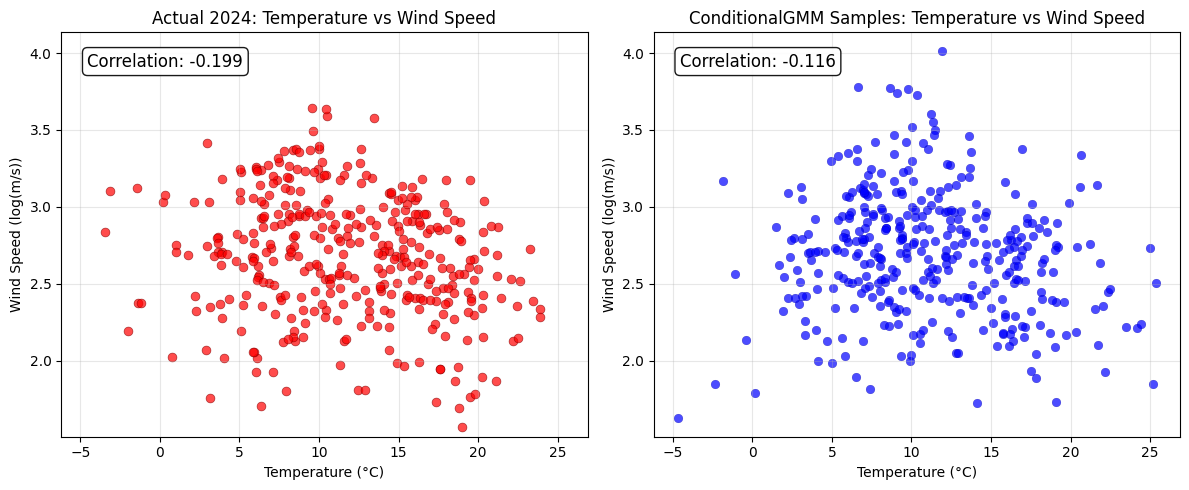

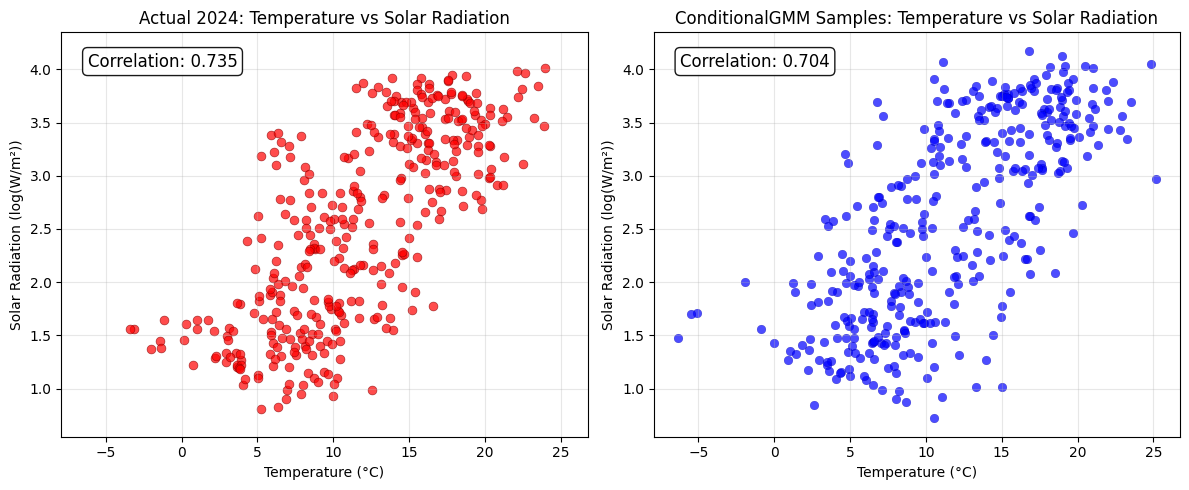

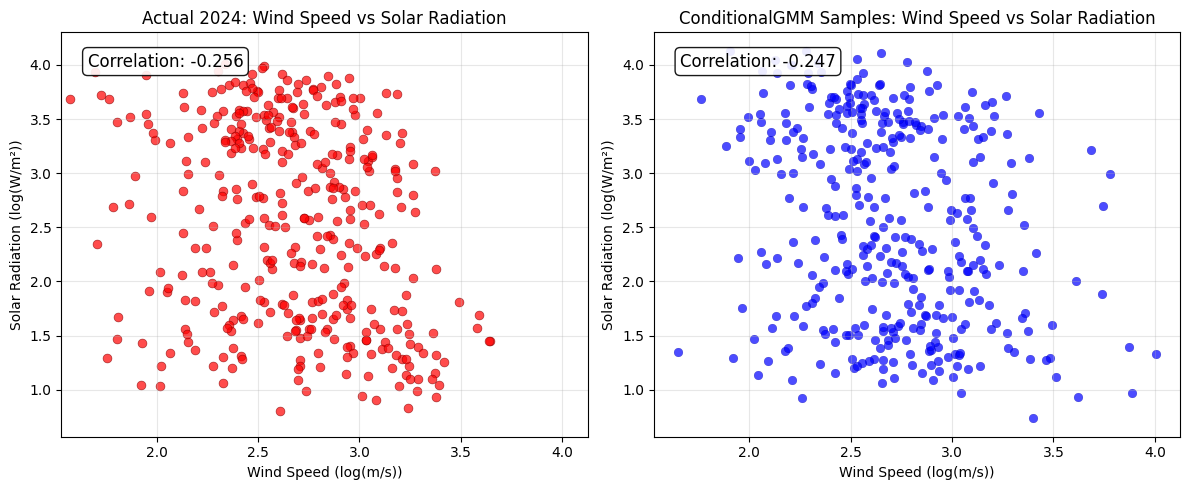


Temporal pattern analysis (first 50 days):


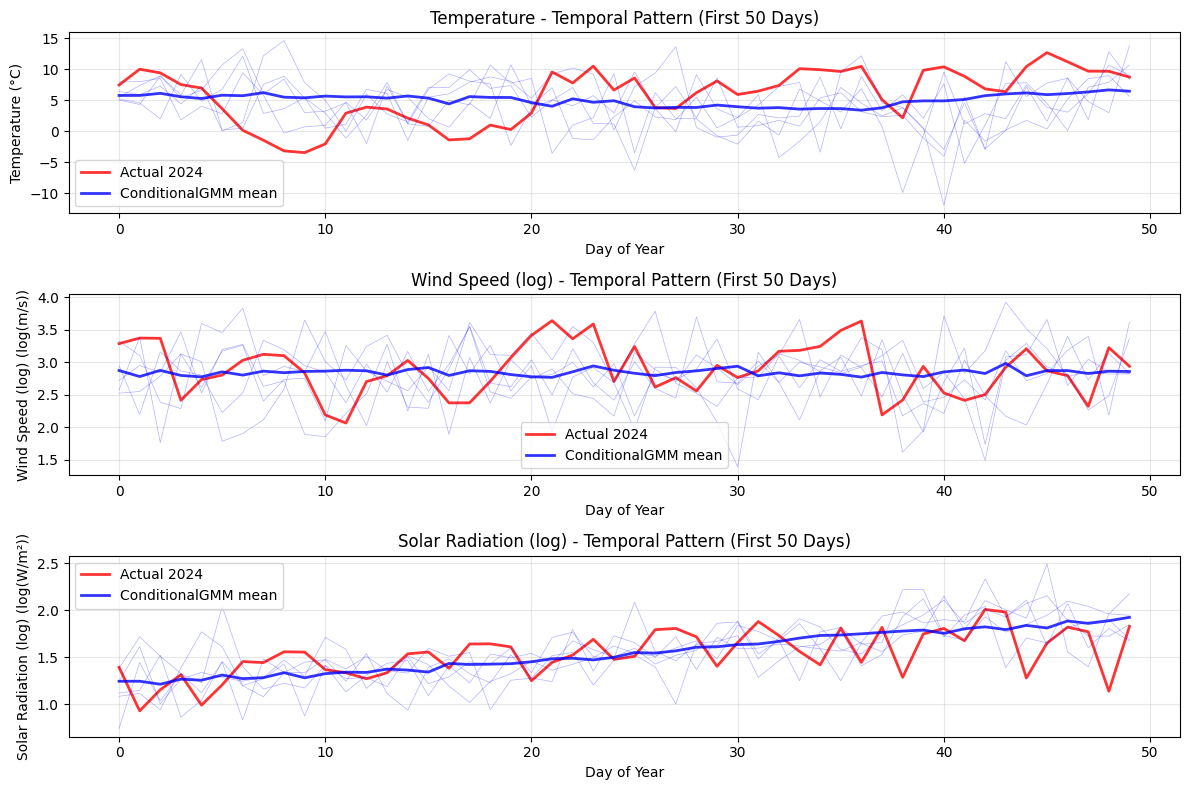


Correlation Summary:
Temperature vs Wind Speed: -0.199
Temperature vs Solar Radiation: 0.735
Wind Speed vs Solar Radiation: -0.256

ConditionalGMM Model Correlations:
Temperature vs Wind Speed: -0.133
Temperature vs Solar Radiation: 0.687
Wind Speed vs Solar Radiation: -0.278


In [31]:
# Plot pairwise joint distributions for 2024 samples
print("=== PAIRWISE JOINT DISTRIBUTIONS FOR 2024 SAMPLES ===")

# Define variable information
variable_names = ['Temperature', 'Wind Speed (log)', 'Solar Radiation (log)']
variable_units = ['°C', 'log(m/s)', 'log(W/m²)']
variable_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Get the first model for comparison
if daily_samples:
    first_model_name = list(daily_samples.keys())[0]
    model_samples = daily_samples[first_model_name]
    print(f"Using {first_model_name} samples for comparison")
    
    # Debug: Check sample independence and variance
    print(f"\nSample independence and variance analysis:")
    print(f"Model samples shape: {model_samples.shape}")
    
    for i, var_name in enumerate(variable_names):
        samples_reshaped = model_samples[:, :, i]  # (n_days, n_samples)
        samples_flat = samples_reshaped.flatten()
        actual_flat = y_daily_2024[:, i]
        
        # Check if samples are independent by looking at correlations between consecutive samples
        if len(samples_flat) > 1:
            consecutive_corr = np.corrcoef(samples_flat[:-1], samples_flat[1:])[0, 1]
        else:
            consecutive_corr = 0
            
        print(f"{var_name}:")
        print(f"  Actual variance: {np.var(actual_flat):.4f}")
        print(f"  Sample variance: {np.var(samples_flat):.4f}")
        print(f"  Consecutive sample correlation: {consecutive_corr:.6f} (should be ~0 for independence)")
        print(f"  Sample range: [{samples_flat.min():.3f}, {samples_flat.max():.3f}]")
        print(f"  Actual range: [{actual_flat.min():.3f}, {actual_flat.max():.3f}]")
        
        # Show first few samples to check for patterns
        print(f"  First 3 days, first 3 samples: {samples_reshaped[:3, :3]}")
        
        # Check if samples within each day are correlated
        if samples_reshaped.shape[1] > 1:
            within_day_corr = np.corrcoef(samples_reshaped[0, :-1], samples_reshaped[0, 1:])[0, 1]
            print(f"  Within-day sample correlation (day 0): {within_day_corr:.6f}")
else:
    print("No model samples available")
    model_samples = None

# Create separate plots for each pair with left/right subplots
pairs = [(0, 1), (0, 2), (1, 2)]  # (temp, wind), (temp, solar), (wind, solar)
pair_names = [('Temperature', 'Wind Speed'), ('Temperature', 'Solar Radiation'), ('Wind Speed', 'Solar Radiation')]

for idx, ((i, j), (name_i, name_j)) in enumerate(zip(pairs, pair_names)):
    # Create a separate figure for each pair
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Left subplot: Actual 2024 data
    ax_left.scatter(y_daily_2024[:, i], y_daily_2024[:, j], alpha=0.7, s=40, 
                   color='red', edgecolors='darkred', linewidth=0.5)
    
    # Calculate and display correlation for actual data
    corr_actual = np.corrcoef(y_daily_2024[:, i], y_daily_2024[:, j])[0, 1]
    ax_left.text(0.05, 0.95, f'Correlation: {corr_actual:.3f}', 
                transform=ax_left.transAxes, ha='left', va='top', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax_left.set_xlabel(f'{name_i} ({variable_units[i]})')
    ax_left.set_ylabel(f'{name_j} ({variable_units[j]})')
    ax_left.set_title(f'Actual 2024: {name_i} vs {name_j}')
    ax_left.grid(True, alpha=0.3)
    
    # Right subplot: Model samples
    if model_samples is not None:
        samples_i = model_samples[:, :, i].flatten()
        samples_j = model_samples[:, :, j].flatten()
        
        # Shuffle samples to break up clustering and remove streaks
        n_samples = len(samples_i)
        shuffle_idx = np.random.permutation(n_samples)[:365]
        samples_i_shuffled = samples_i[shuffle_idx]
        samples_j_shuffled = samples_j[shuffle_idx]
        
        ax_right.scatter(samples_i_shuffled, samples_j_shuffled, alpha=0.7, s=40, 
                        color='blue', edgecolors='darkblue', linewidth=0.2)
        
        # Calculate and display correlation for model samples
        corr_model = np.corrcoef(samples_i_shuffled, samples_j_shuffled)[0, 1]
        ax_right.text(0.05, 0.95, f'Correlation: {corr_model:.3f}', 
                     transform=ax_right.transAxes, ha='left', va='top', fontsize=12,
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        
        ax_right.set_xlabel(f'{name_i} ({variable_units[i]})')
        ax_right.set_ylabel(f'{name_j} ({variable_units[j]})')
        ax_right.set_title(f'{first_model_name} Samples: {name_i} vs {name_j}')
        ax_right.grid(True, alpha=0.3)
        
        # Set same axis limits for fair comparison
        ax_left.set_xlim(ax_right.get_xlim())
        ax_left.set_ylim(ax_right.get_ylim())
    else:
        ax_right.text(0.5, 0.5, 'No model samples available', 
                     transform=ax_right.transAxes, ha='center', va='center', fontsize=14)
        ax_right.set_title('Model Samples: Not Available')
    
    plt.tight_layout()
    plt.show()

# Debug: Plot temporal patterns to understand the streaks
if model_samples is not None:
    print(f"\nTemporal pattern analysis (first 50 days):")
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    
    for i, var_name in enumerate(variable_names):
        ax = axes[i]
        
        # Plot actual data
        ax.plot(y_daily_2024[:50, i], 'r-', linewidth=2, label='Actual 2024', alpha=0.8)
        
        # Plot mean of samples for each day
        sample_means = model_samples[:50, :, i].mean(axis=1)
        ax.plot(sample_means, 'b-', linewidth=2, label=f'{first_model_name} mean', alpha=0.8)
        
        # Plot individual samples (first 5 samples per day)
        for j in range(5):
            ax.plot(model_samples[:50, j, i], 'b-', alpha=0.3, linewidth=0.5)
        
        ax.set_xlabel('Day of Year')
        ax.set_ylabel(f'{var_name} ({variable_units[i]})')
        ax.set_title(f'{var_name} - Temporal Pattern (First 50 Days)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Print correlation summary
print("\nCorrelation Summary:")
print(f"Temperature vs Wind Speed: {np.corrcoef(y_daily_2024[:, 0], y_daily_2024[:, 1])[0, 1]:.3f}")
print(f"Temperature vs Solar Radiation: {np.corrcoef(y_daily_2024[:, 0], y_daily_2024[:, 2])[0, 1]:.3f}")
print(f"Wind Speed vs Solar Radiation: {np.corrcoef(y_daily_2024[:, 1], y_daily_2024[:, 2])[0, 1]:.3f}")

if model_samples is not None:
    print(f"\n{first_model_name} Model Correlations:")
    print(f"Temperature vs Wind Speed: {np.corrcoef(model_samples[:, :, 0].flatten(), model_samples[:, :, 1].flatten())[0, 1]:.3f}")
    print(f"Temperature vs Solar Radiation: {np.corrcoef(model_samples[:, :, 0].flatten(), model_samples[:, :, 2].flatten())[0, 1]:.3f}")
    print(f"Wind Speed vs Solar Radiation: {np.corrcoef(model_samples[:, :, 1].flatten(), model_samples[:, :, 2].flatten())[0, 1]:.3f}")
